## **1. Import Data**

In [1]:
# Supress warnings

import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, datetime, pytz, re, os, statsmodels.api as sm

#from sdv.tabular import CTGAN, CopulaGAN
from sklearn import (metrics, preprocessing, model_selection, feature_selection, linear_model, ensemble)
from sklearn.decomposition import PCA
from imblearn.over_sampling import (SMOTE, ADASYN)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# load train data

df_train = pd.read_csv('aug_train.csv')
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [3]:
# copy of train and test data

df_train_org = df_train.copy()

## **2. Data Understanding**

In [4]:
# shape of dataset

df_train.shape

(382154, 12)

In [5]:
# info of dataset

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


In [6]:
# Statistics summary of numerical variables

df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,234392.953477,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,154.189429,0.163811
std,139527.487326,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,83.735107,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,115006.250000,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,81.000000,0.000000
50%,230461.500000,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,154.000000,0.000000
75%,345434.750000,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,227.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


From ``info`` and ``describe`` of dataframe, it is evident that **Region_Code** and **Policy_Sales_Channel** were interpreted as continuous variables. ``Region_code`` referes to region of the customer and ``Policy_Sales_Channel`` referes to the channel through which customer has purchased the insurance. So, these columns must be interpreted as categorical variables

## **3. Data Cleaning**

In [7]:
# Converting datatype of Region_Code and Policy_Sales_Channel

df_train[['Region_Code', 'Policy_Sales_Channel']] = df_train[['Region_Code', 'Policy_Sales_Channel']].astype('int').astype('str')
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7,1,< 1 Year,No,2630.0,152,16,0
1,17163,Male,42,1,28,0,1-2 Year,Yes,43327.0,26,135,0
2,32023,Female,66,1,33,0,1-2 Year,Yes,35841.0,124,253,0
3,87447,Female,22,1,33,0,< 1 Year,No,27645.0,152,69,0
4,501933,Male,28,1,46,1,< 1 Year,No,29023.0,152,211,0


In [8]:
# info of dataset

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  object 
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  object 
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 35.0+ MB


In [9]:
# Column wise null value count

df_train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

From the column wise null values counts, it is confirmed that there are no null values in the data.

In [10]:
# value_counts function

def value_count_percentage(df, col):
  return df[col].value_counts(normalize=True)*100

# perform buckteing of categorical variables

def bucket_insignificant_cat_levels(df, col_name, threshold):
    counts_df = pd.DataFrame(value_count_percentage(df, col_name))
    other_list = list(counts_df[counts_df[col_name]<threshold].index)
    df[col_name] = df[col_name].apply(lambda x : 'Other' if x in other_list else x)
    return df, value_count_percentage(df, col_name)

In [11]:
# value counts of 'Gender'

value_count_percentage(df_train, 'Gender')

Male      53.801085
Female    46.198915
Name: Gender, dtype: float64

In [12]:
# value counts of 'Driving_License'

value_count_percentage(df_train, 'Driving_License')

1    99.810809
0     0.189191
Name: Driving_License, dtype: float64

In [13]:
# value counts of 'Region_Code'

value_count_percentage(df_train, 'Region_Code')

28    28.051257
8      8.881498
46     5.286612
41     4.995368
15     3.420349
30     3.334258
29     3.048509
50     2.662801
11     2.457648
3      2.427294
36     2.255373
33     2.095490
35     1.898188
47     1.897403
6      1.717894
45     1.453602
18     1.410950
37     1.312560
14     1.278019
10     1.179891
39     1.171256
21     1.159480
48     1.133836
13     1.054549
2      0.974215
7      0.859339
12     0.827415
9      0.768277
32     0.710185
43     0.675121
27     0.665700
17     0.658635
25     0.646598
26     0.637963
24     0.624094
38     0.527013
23     0.524658
16     0.523611
0      0.481220
4      0.477556
31     0.458454
20     0.447464
49     0.447202
34     0.403764
19     0.385447
22     0.329972
40     0.325000
5      0.317411
1      0.245974
44     0.205153
42     0.148370
52     0.068820
51     0.051288
Name: Region_Code, dtype: float64

In [14]:
# value counts of 'Previously_Insured'

value_count_percentage(df_train, 'Previously_Insured')

0    51.081763
1    48.918237
Name: Previously_Insured, dtype: float64

In [15]:
# value counts of 'Vehicle_Age'

value_count_percentage(df_train, 'Vehicle_Age')

1-2 Year     52.380977
< 1 Year     43.530357
> 2 Years     4.088666
Name: Vehicle_Age, dtype: float64

In [16]:
# value counts of 'Vehicle_Damage'

value_count_percentage(df_train, 'Vehicle_Damage')

No     51.942672
Yes    48.057328
Name: Vehicle_Damage, dtype: float64

In [17]:
# value counts of 'Policy_Sales_Channel'

value_count_percentage(df_train, 'Policy_Sales_Channel')

152    35.959849
26     21.343751
124    19.184674
160     5.506942
156     2.644484
         ...    
84      0.000262
50      0.000262
144     0.000262
149     0.000262
143     0.000262
Name: Policy_Sales_Channel, Length: 156, dtype: float64

In [18]:
# value counts of 'Response'

value_count_percentage(df_train, 'Response')

0    83.618908
1    16.381092
Name: Response, dtype: float64

``Driving_License`` column is heavily skewed as it has 99.8% of 1's and 0.2% of 0's. ``Driving_License`` column can be dropped along with the ``id`` column which is a primary key column and doesn't add any information to our data.

Output variable ``Response`` is also a highly skewed variable. So, we need to balance the data with appropriate methods.

``Region_Code`` and ``Policy_Sales_Channel`` columns have very high categorical levels. Lets perform buckteing on these variables. All categorical levels whose contribution is less that 1% are buckted into ``Other`` category.

In [19]:
# Bucketing the categorical variable 'Region_Code'

df_train_region_buckted, region_count_df = bucket_insignificant_cat_levels(df_train, 'Region_Code', 1)
print(region_count_df)
df_train_region_buckted.head()

28       28.051257
Other    14.415916
8         8.881498
46        5.286612
41        4.995368
15        3.420349
30        3.334258
29        3.048509
50        2.662801
11        2.457648
3         2.427294
36        2.255373
33        2.095490
35        1.898188
47        1.897403
6         1.717894
45        1.453602
18        1.410950
37        1.312560
14        1.278019
10        1.179891
39        1.171256
21        1.159480
48        1.133836
13        1.054549
Name: Region_Code, dtype: float64


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,Other,1,< 1 Year,No,2630.0,152,16,0
1,17163,Male,42,1,28,0,1-2 Year,Yes,43327.0,26,135,0
2,32023,Female,66,1,33,0,1-2 Year,Yes,35841.0,124,253,0
3,87447,Female,22,1,33,0,< 1 Year,No,27645.0,152,69,0
4,501933,Male,28,1,46,1,< 1 Year,No,29023.0,152,211,0


In [20]:
# Bucketing the categorical variable 'Policy_Sales_Channel'

df_train_policy_channel_buckted, policy_channel_count_df = bucket_insignificant_cat_levels(df_train, 'Policy_Sales_Channel', 1)
print(policy_channel_count_df)
df_train_policy_channel_buckted.head()

152      35.959849
26       21.343751
124      19.184674
Other     9.507424
160       5.506942
156       2.644484
122       2.550019
157       1.763425
154       1.539432
Name: Policy_Sales_Channel, dtype: float64


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,Other,1,< 1 Year,No,2630.0,152,16,0
1,17163,Male,42,1,28,0,1-2 Year,Yes,43327.0,26,135,0
2,32023,Female,66,1,33,0,1-2 Year,Yes,35841.0,124,253,0
3,87447,Female,22,1,33,0,< 1 Year,No,27645.0,152,69,0
4,501933,Male,28,1,46,1,< 1 Year,No,29023.0,152,211,0


In [21]:
# drop id and Driving_License

df_train_drop = df_train_policy_channel_buckted.drop(columns=['id', 'Driving_License'])
df_train_drop.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,Other,1,< 1 Year,No,2630.0,152,16,0
1,Male,42,28,0,1-2 Year,Yes,43327.0,26,135,0
2,Female,66,33,0,1-2 Year,Yes,35841.0,124,253,0
3,Female,22,33,0,< 1 Year,No,27645.0,152,69,0
4,Male,28,46,1,< 1 Year,No,29023.0,152,211,0


## **4. Exploratory Data Analysis**

### **4.1 Univariate Analysis**

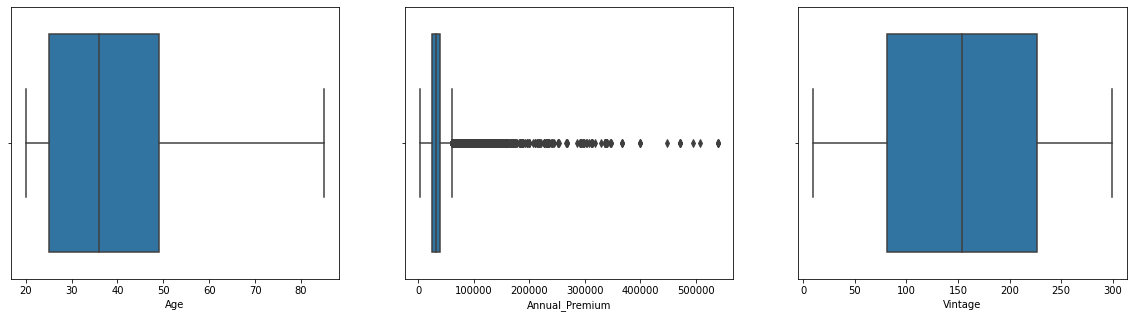

In [22]:
# Box plots of 'Age', 'Annual_Premium', and 'Vintage'

cont_vars = ['Age', 'Annual_Premium', 'Vintage']

plt.figure(figsize=(20,5))

for i in range(len(cont_vars)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(cont_vars[i], data=df_train_drop)

In [23]:
# summary of continuous variables

df_train_drop[cont_vars].describe()

,Age,Annual_Premium,Vintage
count,382154.000000,382154.000000,382154.000000
mean,38.545691,30711.271362,154.189429
std,15.226897,17061.595532,83.735107
min,20.000000,2630.000000,10.000000
25%,25.000000,24546.000000,81.000000
50%,36.000000,31692.000000,154.000000
75%,49.000000,39447.750000,227.000000
max,85.000000,540165.000000,299.000000


From the box plots and summary of continuous variables, we can confirm that there are no outliers in ``Age`` and ``Vintage`` columns. The difference between mean and 50% of ``Annual_Preminum`` is insignificant and the box plot of the column reveals that there is no sudden increase in the values. Although there are few data points with higher values beyond 300000, they are high premium paying customers and manipulating the data will lead to moss of meaningful information.

In [24]:
# Function to create distribution plot of continuous variable

def univariate_histogram_plot(df, var):
    
    plt.figure(figsize=(20,5))

    for i in range(len(var)):    
        plt.subplot(1, 3, i+1)
        #plt.yscale("log")
        sns.distplot(df[var[i]])

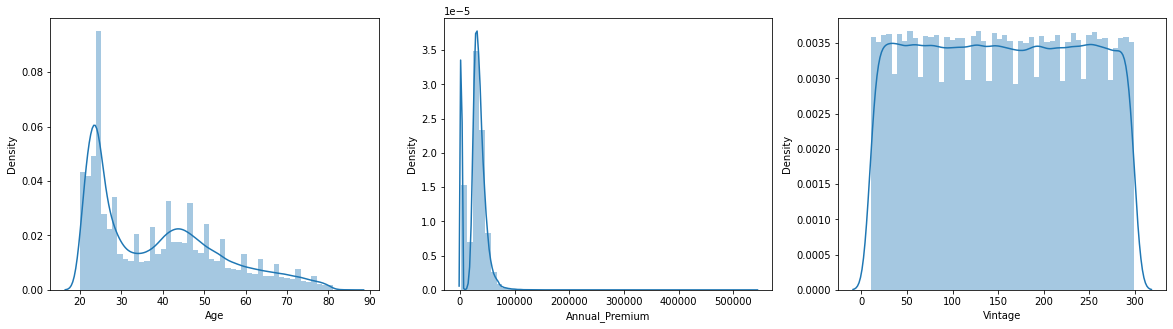

In [25]:
# distribution plots of continuous variables

univariate_histogram_plot(df_train_drop, var = cont_vars)

From the distribution plots, most of the values in ``Age`` and ``Annual_Premium`` are concentrated in the range of 20 to 30 years range and $0 to $100000 premium respectively. The distribution of ``Vintage`` variable is very similar to uniform distribution.

In [26]:
# Function to create count plot of categorical variables

def univariate_count_plot(df, var):
    
    plt.figure(figsize=(20,15))
    
    for i in range(len(var)):
        plt.subplot(3, 3, i+1)
        sns.countplot(df[var[i]])

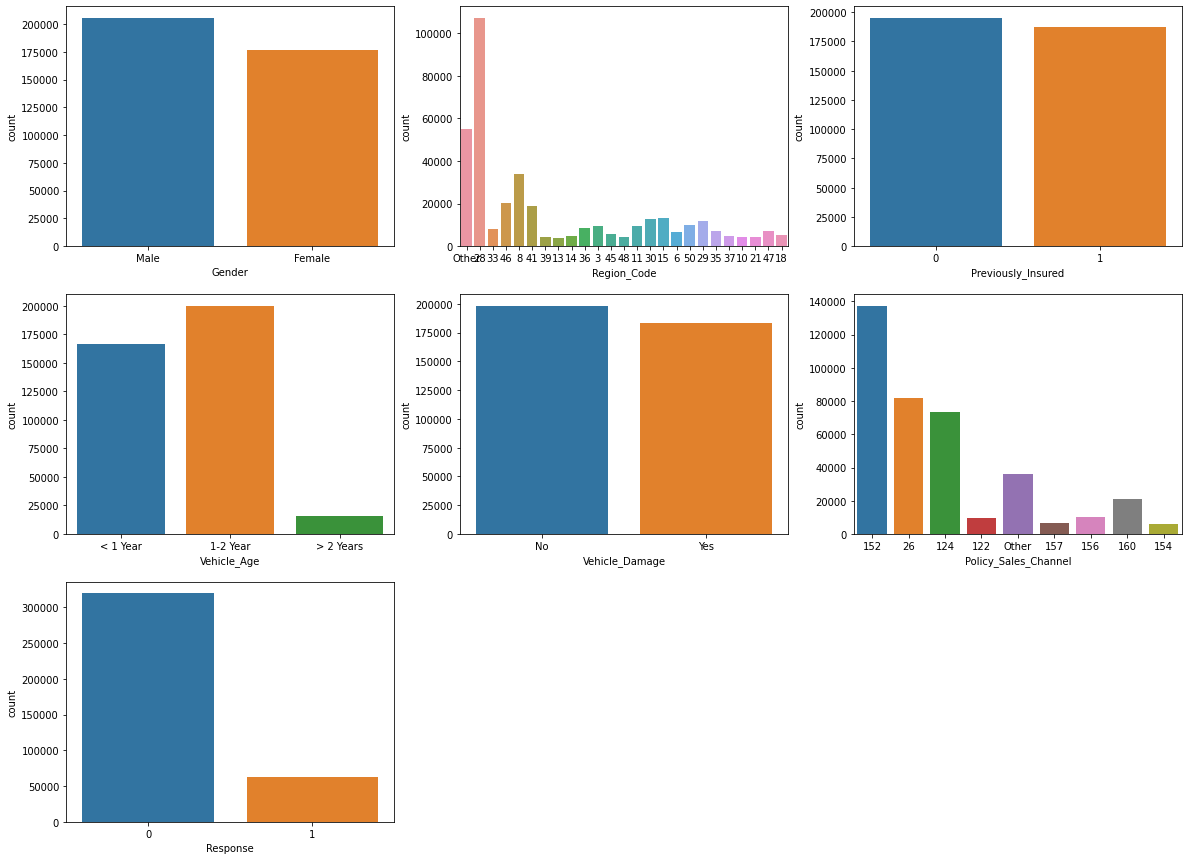

In [27]:
# Count plots of categorical variables

univariate_count_plot(df_train_drop, var = ['Gender', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Response'])

- Plots of ``Gender``, ``Previously_Insured`` and ``Vehicle_Damage`` reveals that the company has contacted almost equal number of Male and Female customers, customers with and without Insurance, and customers with and without vehicle damage as the difference between the categories of respective columns is small/insignificant. 
- From ``Region_Code`` plot, we can confirm that most of the customers are from region with code 28. Regions with codes 46, 8, and 41 has >= 20000 customers. There are also significant customers from regions with codes 30, 15, and 29.
- ``Vehicle_Age`` plot reveals that the company has heavily contacted the customers who have purchased the vehicle recently.
- Sales team of Insurance company has major number interaction with customers from channel 152, 26, and 124.
- ``Response`` is our target variable which is highly imbalanced and should be treated with class balancing techniques. 

### **4.2 Bivariate Analysis**

In [28]:
# Function to create Bar plot

def bivariate_bar_plot(df, feature_name1, feature_name2, feature_name3='', estimator=np.sum):
    if feature_name3:
        sns.barplot(feature_name1, feature_name2, data=df, estimator=estimator, hue=feature_name3)
    else:
        sns.barplot(feature_name1, feature_name2, data=df, estimator=estimator)

In [29]:
# Function to create Bar plot with 2 difference estimators for categorical-categorical analysis

def bivariate_sum_mean_var_plot(df, feature_name1, feature_name2, feature_name3='', estimator=np.sum):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    plt.title('Sum of '+feature_name2)
    bivariate_bar_plot(df_train_drop, feature_name1, feature_name2, feature_name3)
    
    plt.subplot(1,2,2)
    plt.title('b')
    plt.title('Mean of '+feature_name2)
    bivariate_bar_plot(df_train_drop, feature_name1, feature_name2, feature_name3, estimator=np.mean)

In [30]:
# Function to create Bar plot with 2 difference estimators for categorical-continuous analysis

def bivariate_mean_median_var_plot(df, feature_name1, feature_name2, feature_name3='', estimator=np.mean):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    plt.title('Mean of '+feature_name2)
    bivariate_bar_plot(df_train_drop, feature_name1, feature_name2, feature_name3, estimator=np.mean)
    
    plt.subplot(1,2,2)
    plt.title('b')
    plt.title('Median of '+feature_name2)
    bivariate_bar_plot(df_train_drop, feature_name1, feature_name2, feature_name3, estimator=np.median)

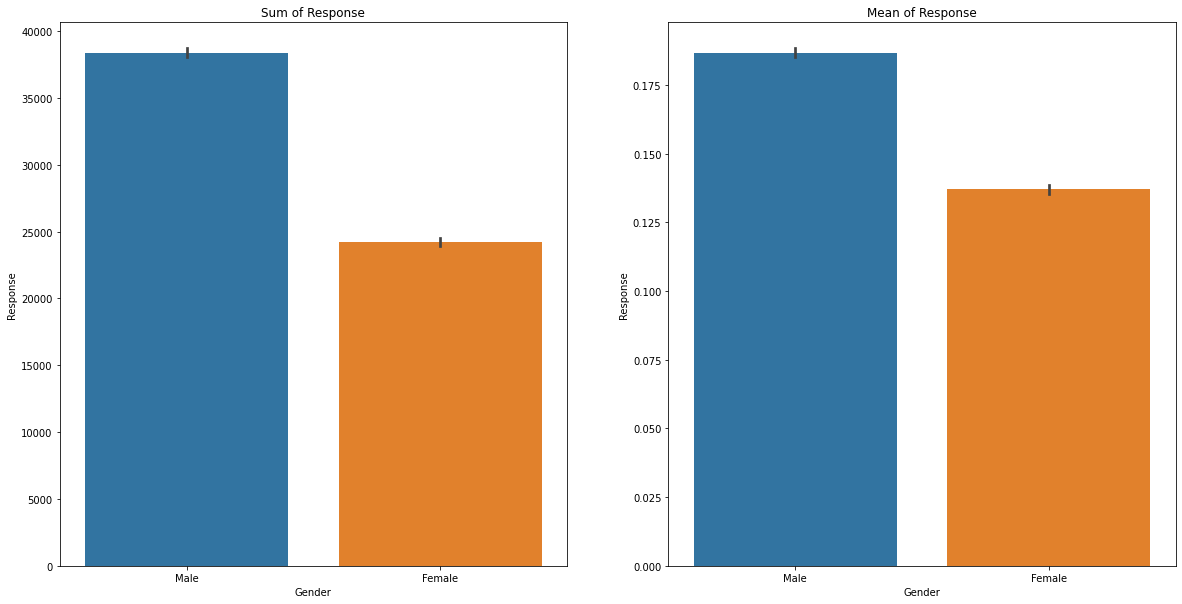

In [31]:
# Bivariate bar plot of 'Gender' and 'Response'

bivariate_sum_mean_var_plot(df_train_drop, 'Gender', 'Response')

From ``Gender`` count plot, we know that there are almost equal number of Male and Female customers, but Male customers have clearly dominated the Female customers in purchasing the insurance as they are more likely to purchase the insurance.

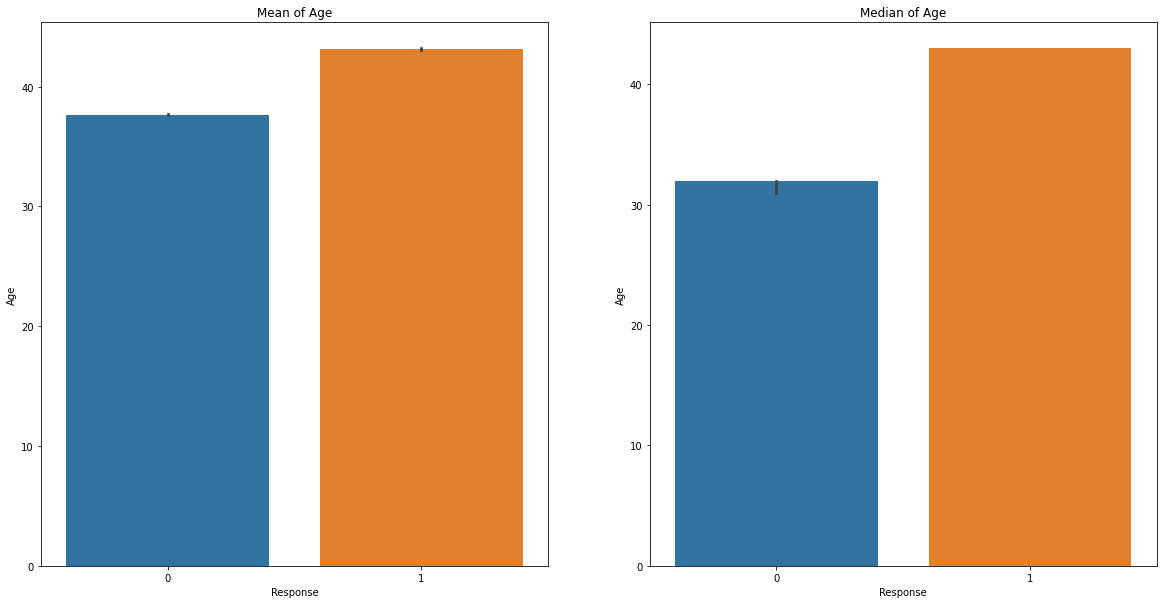

In [32]:
# Bivariate bar plot of 'Response' and 'Age'

bivariate_mean_median_var_plot(df_train_drop, 'Response', 'Age')

There is a significant difference between the mean age and median age of customers who have opted and not opted for Insurance. It is clearly evident that slightly older customers are more likely to opt for insurance.

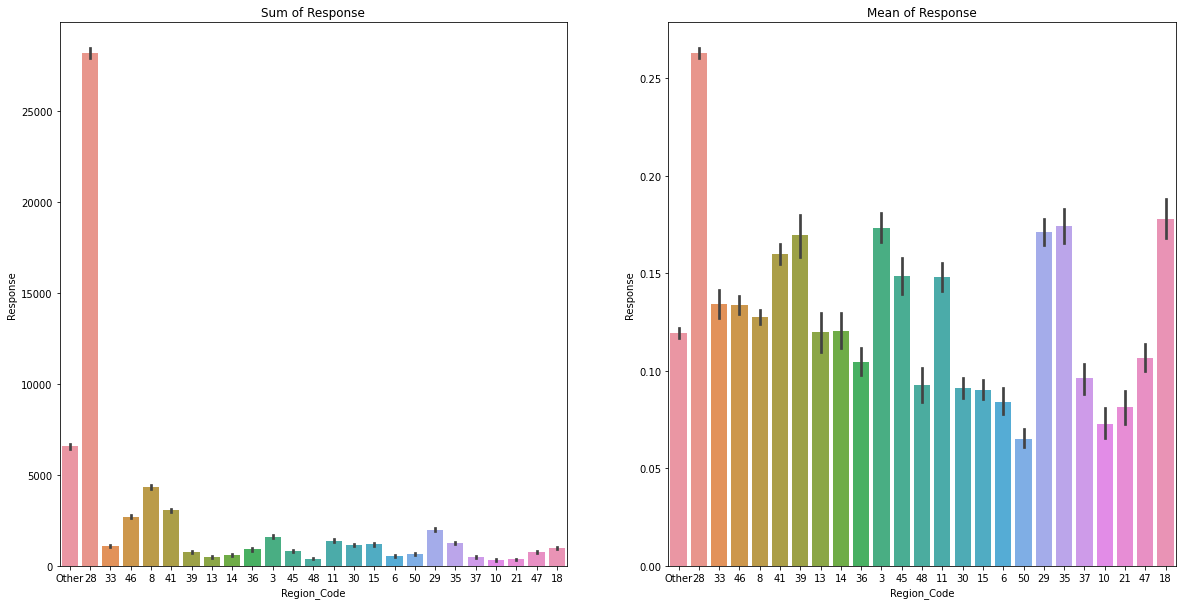

In [33]:
# Bivariate bar plot of 'Region_Code' and 'Response'

bivariate_sum_mean_var_plot(df_train_drop, 'Region_Code', 'Response')

- Customers from region with code 28 have outperformed the other regions in opting for Insurance as they are more likely to purchase the insurance. 
- Customers from regions with codes 46, 8, and 41 also opted for Insurance in significant numbers but customer from regions with codes 39, 3, 29, 35, and 18 are more likely to purchase the insurance than the customers from regions 46, 8, and 41.

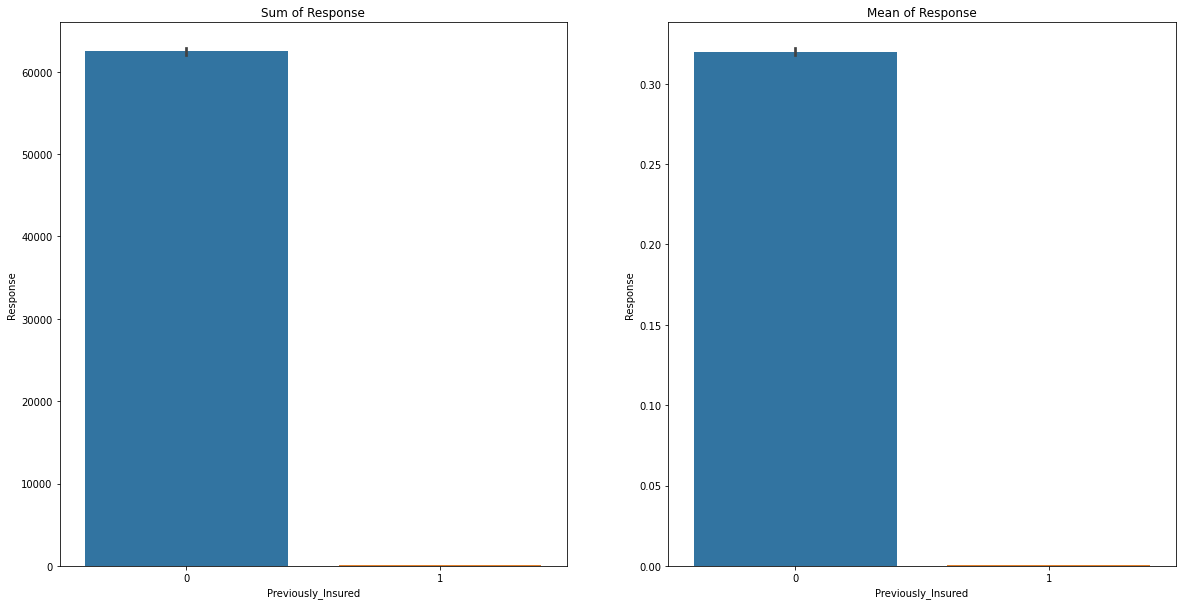

In [34]:
# Bivariate bar plot of 'Previously_Insured' and 'Response'

bivariate_sum_mean_var_plot(df_train_drop, 'Previously_Insured', 'Response')

From ``Previously_Insured`` count plot, we know that there are almost equal number customers from both catogories, but only few customers who have an insurance in the past have opted to purchase the insurance which is negligible/insignificant when compared with the customers who doesn't have insurance in the past.

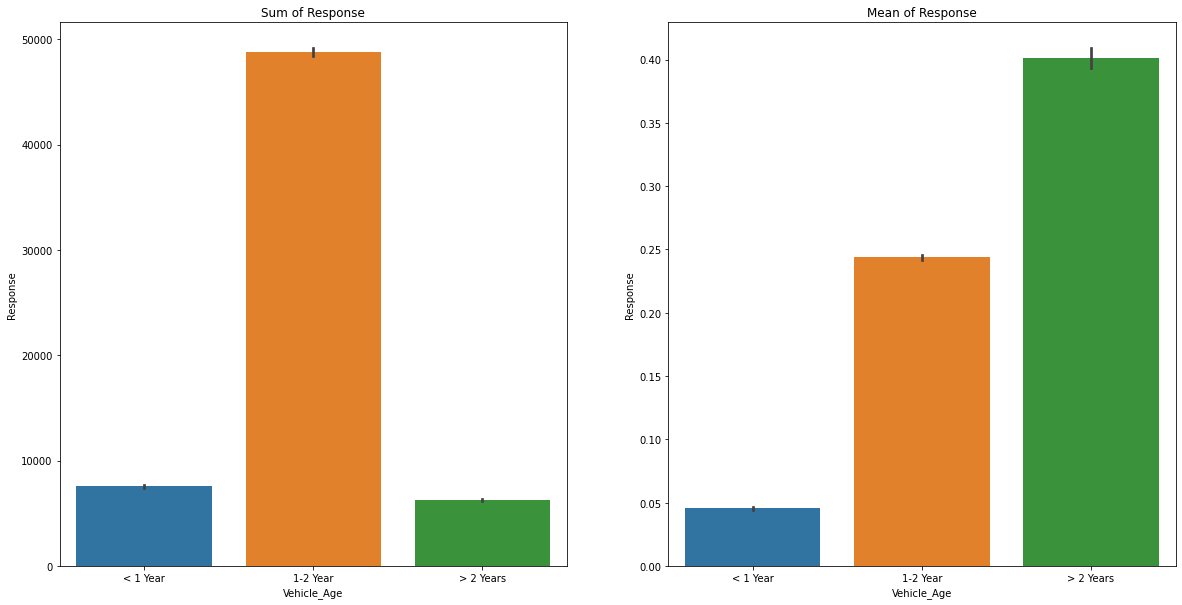

In [35]:
# Bivariate bar plot of 'Vehicle_Age' and 'Response'

bivariate_sum_mean_var_plot(df_train_drop, 'Vehicle_Age', 'Response')

- From the count plot of ``Vehicle_Age``, the number of customers with vehicle age ``< 1 Year`` is way higher that the number of customers with vehicle age ``> 2 Years`` but they have almost equal number of insurance purchases.
- Although the customers with vehicle age ``< 1 Year`` and ``> 2 Years`` purchased the insurance in equal numbers, the likelihood of customers purchasing the insurance with vehicle age ``> 2 Years`` is way higher than likelihood of customers with vehicle age ``< 1 Year``.
- The likelihood of customers purchasing the insurance with vehicle age ``> 2 Years``is significantly greater than likelihood of customers with vehicle age ``1-2 Year`` which has the highest insurance purchases.

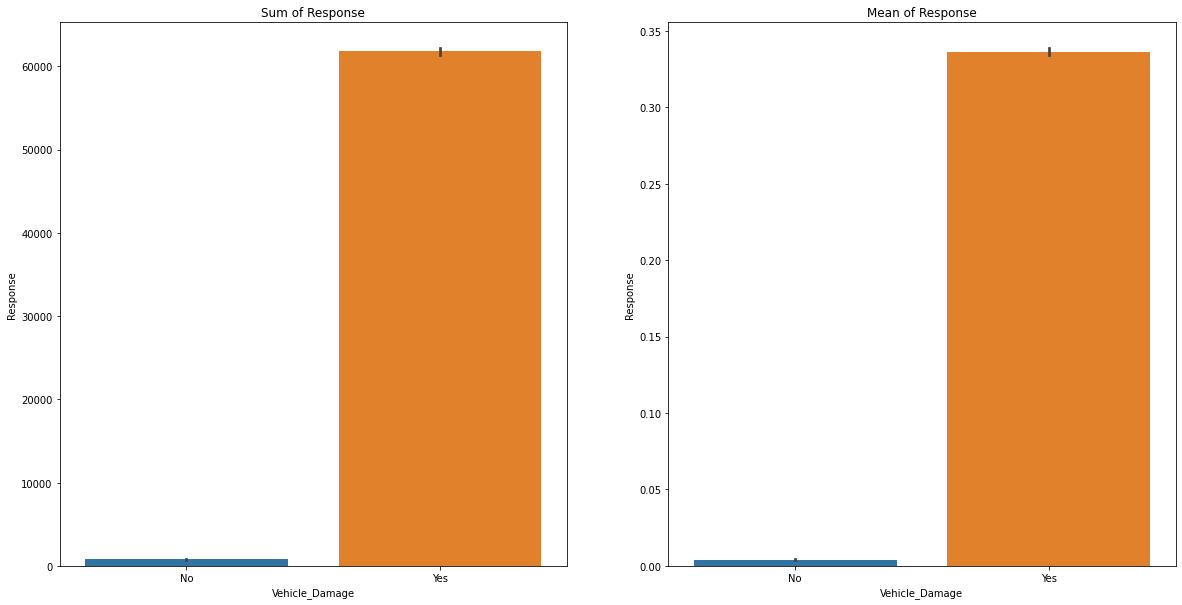

In [36]:
# Bivariate bar plot of 'Vehicle_Damage' and 'Response'

bivariate_sum_mean_var_plot(df_train_drop, 'Vehicle_Damage', 'Response')

From ``Vehicle_Damage`` count plot, we know that there are almost equal number customers from both catogories, but only few customers who doesn't have any vehicle damage have opted to purchase the insurance which is negligible/insignificant when compared with the customers with the damaged category.

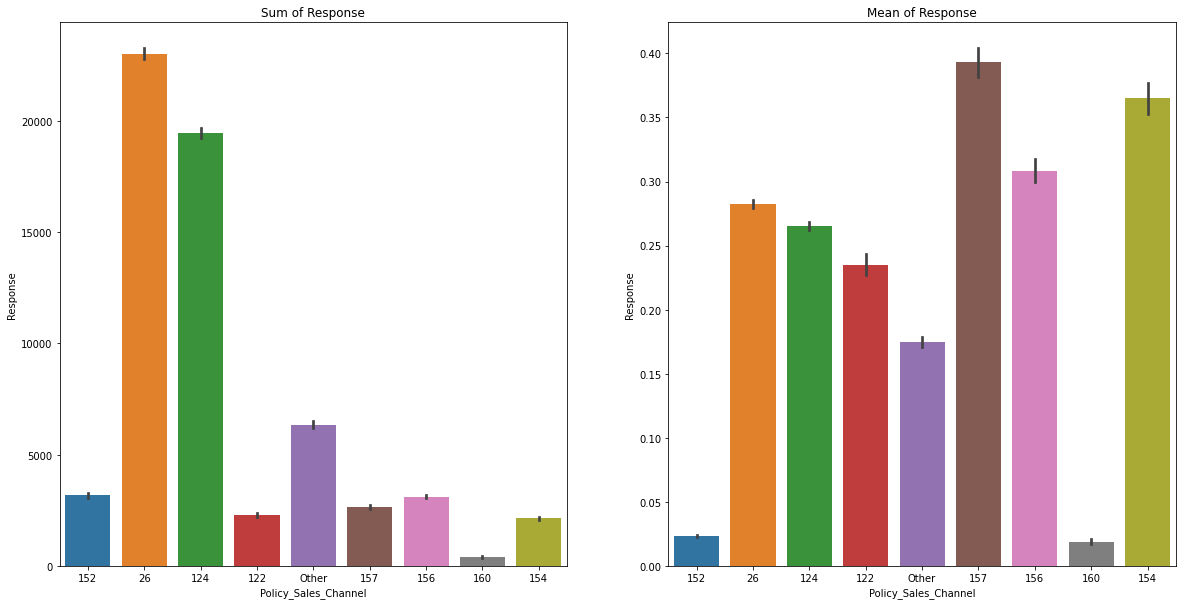

In [37]:
# Bivariate bar plot of 'Policy_sales_Channel' and 'Response'

bivariate_sum_mean_var_plot(df_train_drop, 'Policy_Sales_Channel', 'Response')

- Sales team of Insurance company has highest number of interactions with customers through channel 152 with significant number of interactions from channels 26 and 124, but customers through channels 26 and 124 made the highest number of purchases.
- The customers made the highest purchases through channels ``26`` and ``124`` but the likelihood of customers purchasing the insurance through channels ``157``, ``156`` and ``154`` is greater than the channels ``26`` and ``124``.

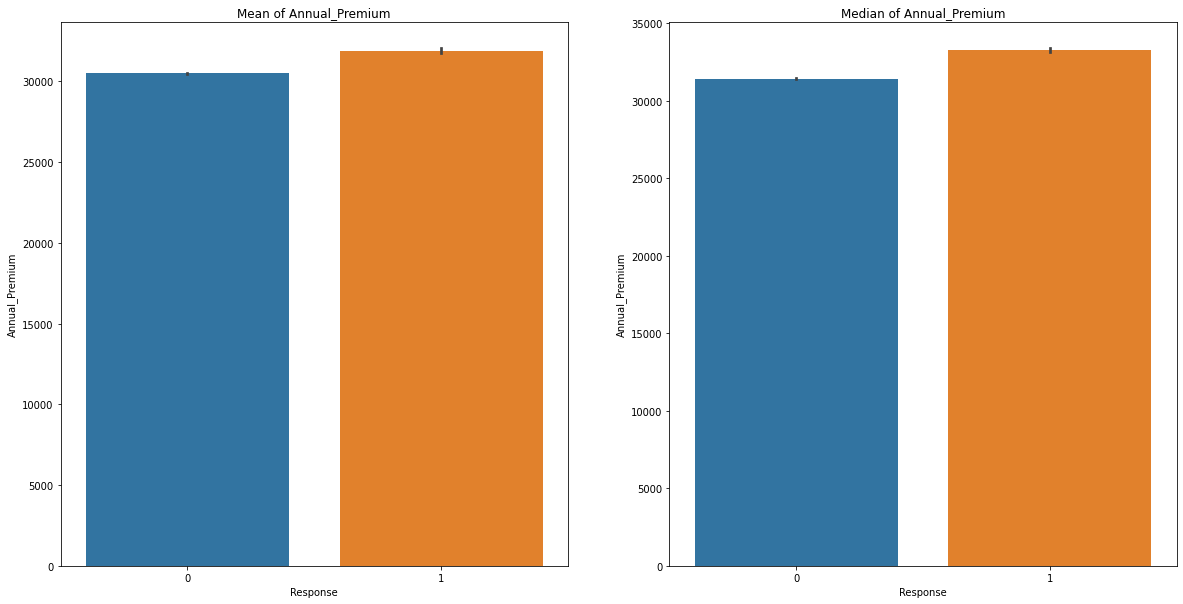

In [38]:
# Bivariate bar plot of 'Response' and 'Annual_Premium'

bivariate_mean_median_var_plot(df_train_drop, 'Response', 'Annual_Premium')

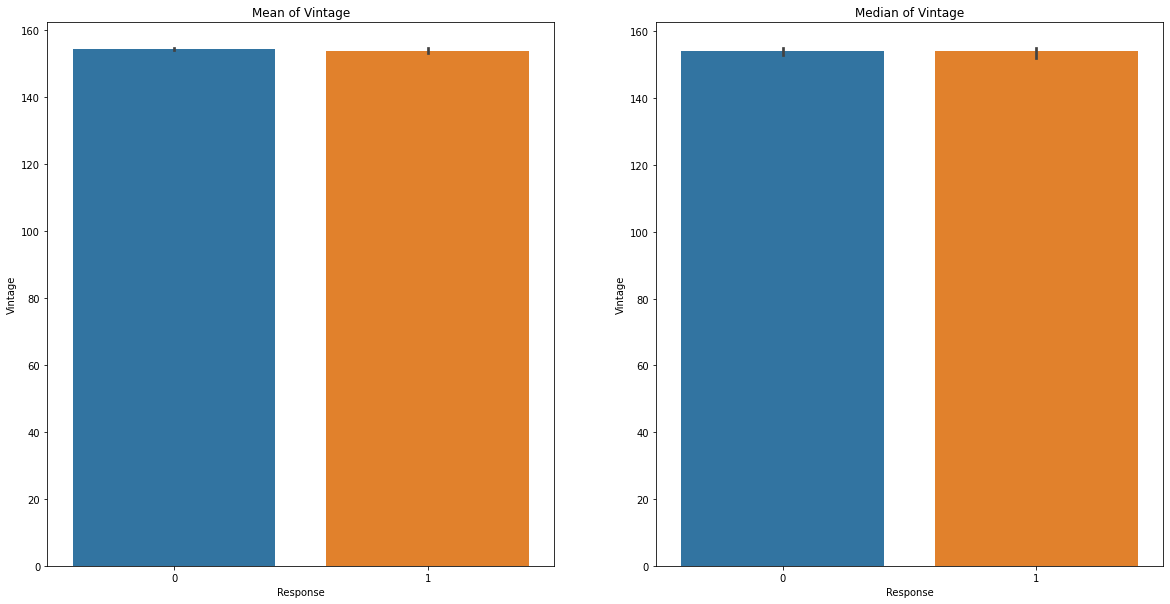

In [39]:
# Bivariate bar plot of 'Response' and 'Vintage'

bivariate_mean_median_var_plot(df_train_drop, 'Response', 'Vintage')

The difference between Mean and Median valeus of ``Annual Premium`` and ``Vintage`` across customers who have purchased the insurance and not purchased insurance is very small/insignificant. 

### **4.3 Multivariate Analysis**

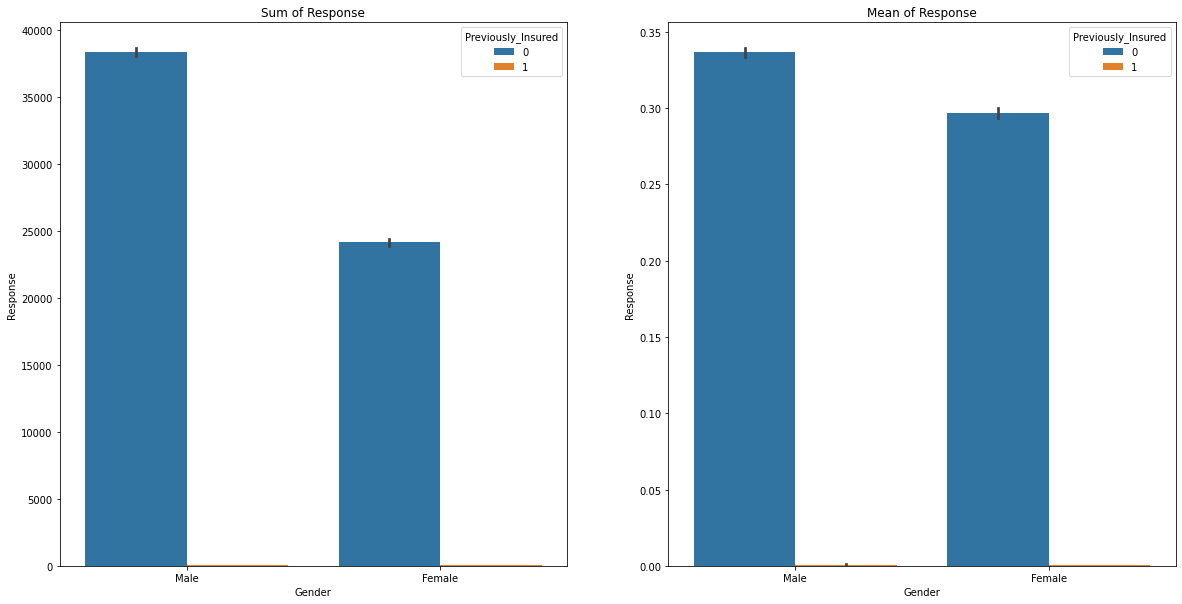

In [40]:
# Bivariate bar plot of 'Gender', 'Response' and 'Previously_Insured'

bivariate_sum_mean_var_plot(df_train_drop, 'Gender', 'Response', 'Previously_Insured')

Male customers who doesn't have any insurance in the past have purchased significantly more insurances than the Female customers, but the likelihood of Female customers purchasing the insurance is close to the likelihood of Male customers.

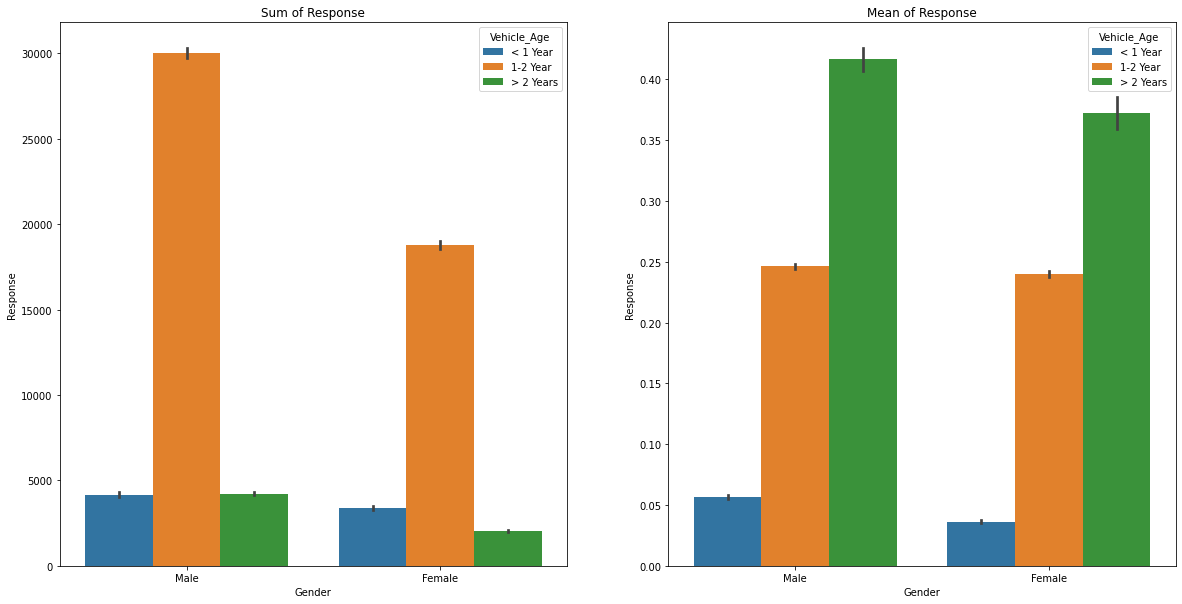

In [41]:
# Bivariate bar plot of 'Gender', 'Response' and 'Vehicle_Age'

bivariate_sum_mean_var_plot(df_train_drop, 'Gender', 'Response', 'Vehicle_Age')

- ``Male`` customers with vehicle age ``1-2 Year`` have clearly outperformed the female customers in purchasing the insurance but the likelihood of Male and Female customers opting for insurance with the same vehicle age category is almost identical.
- Although Male customers have purchased double the insurances then Female customers with vehicle age ``> 2 Years``, the likelihood of Female customers opting for insurance is closer to the likelihood of Male customers opting for insurance.
- In ``< 1 Year`` category, Male and Female customers have purchased the insurance in equal numbers and the likelihood of Male and Female customers also remains closer to each other.

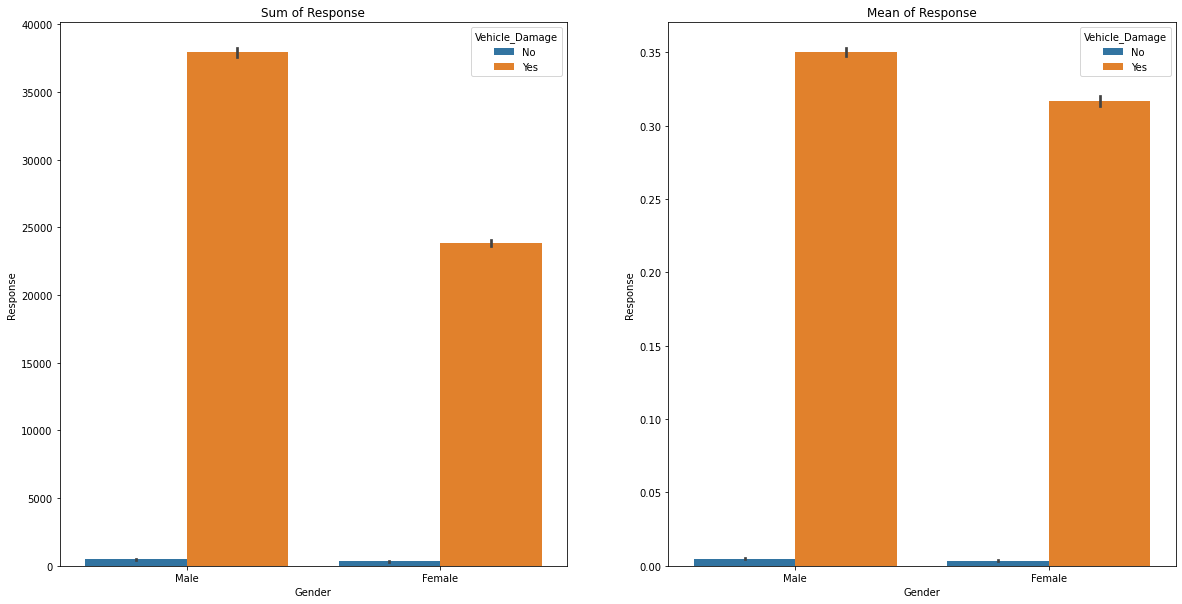

In [42]:
# Bivariate bar plot of 'Gender', 'Response' and 'Vehicle_Damage'

bivariate_sum_mean_var_plot(df_train_drop, 'Gender', 'Response', 'Vehicle_Damage')

Male customers who have vehicle damage in the past have purchased significantly more insurances than the Female customers, but the difference in likelihood of Male and Female customers purchasing the insurance is low.

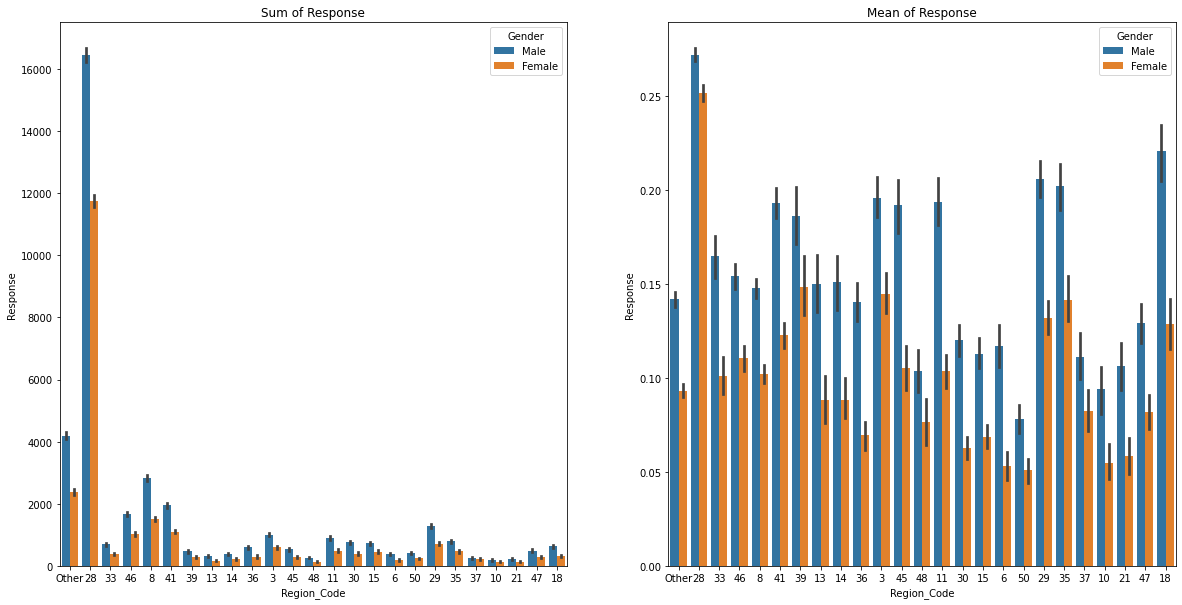

In [43]:
# Bivariate bar plot of 'Region_Code', 'Response' and 'Gender'

bivariate_sum_mean_var_plot(df_train_drop, 'Region_Code', 'Response', 'Gender')

- ``Male`` customers from region with code ``28`` have significantly more insurance purchases than Female customers from same region but the likelihood values of Male and Female customers in purchasing the insurance are close to each other.
- In the other regions, Male customers have slightly more insurance purchases than female customers and Male customers are also more likely to purchase the insurance.

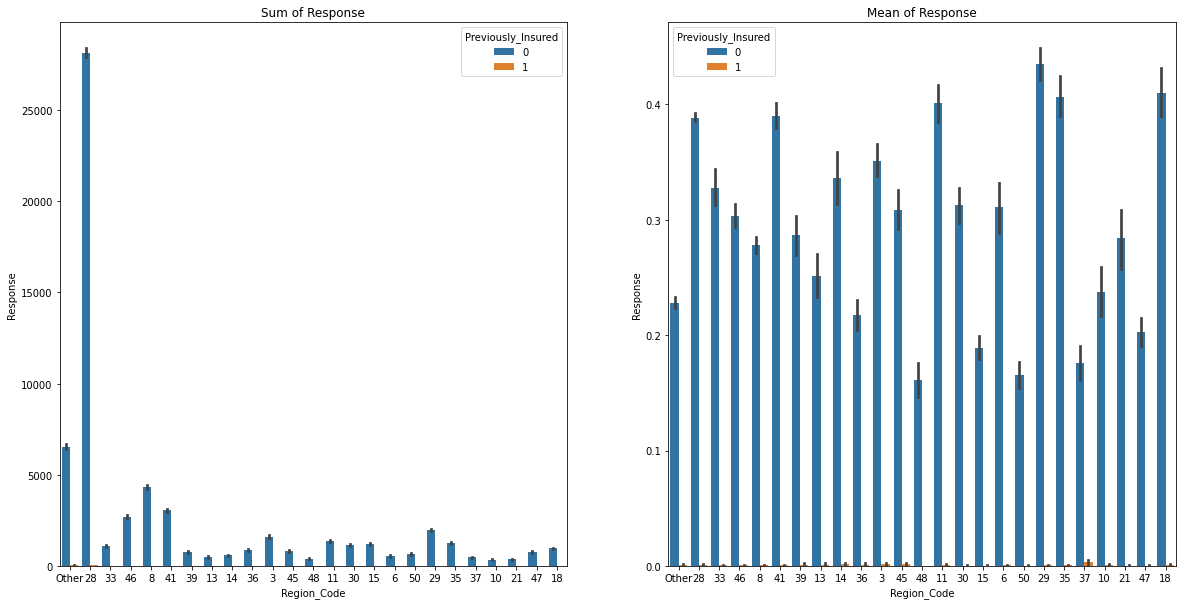

In [44]:
# Bivariate bar plot of 'Region_Code', 'Response' and 'Previously_Insured'

bivariate_sum_mean_var_plot(df_train_drop, 'Region_Code', 'Response', 'Previously_Insured')

In the region with code ``28``, Customers who doesn't have any insurance in the past have purchased ~28000 insurances which is atleast 4x then the other regions, but the likelihood values of customers purchasing the insurance from regions with codes ``41``, ``11``, ``29``, ``35`` and ``18`` are greater than likelihood value of customers purchasing the insurance from region with code 28.

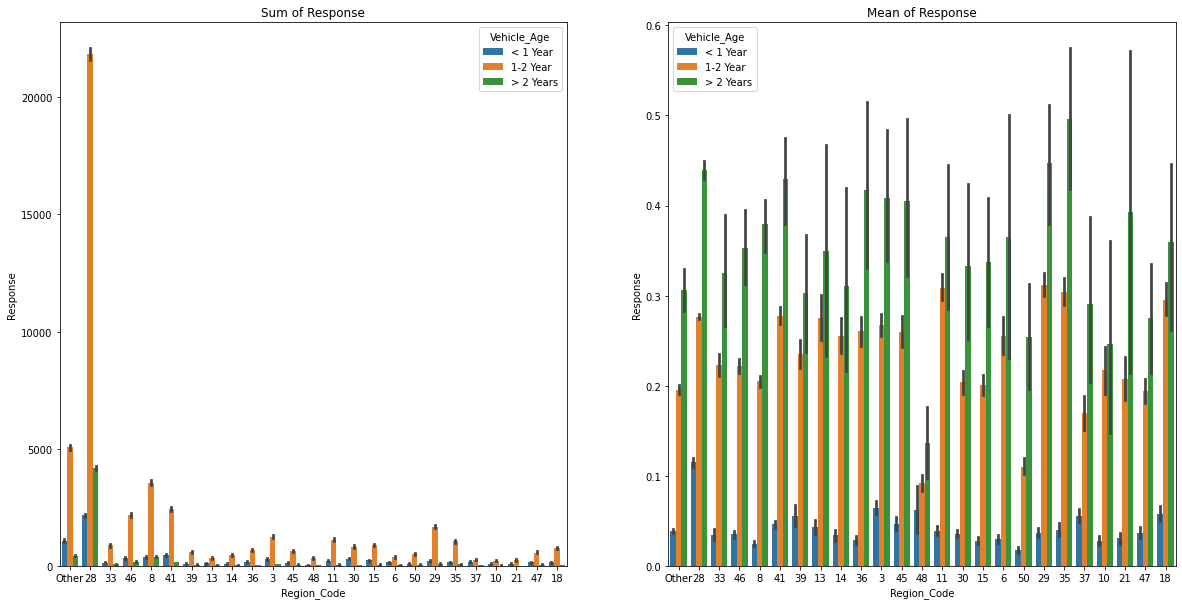

In [45]:
# Bivariate bar plot of 'Region_Code', 'Response' and 'Vehicle_Age'

bivariate_sum_mean_var_plot(df_train_drop, 'Region_Code', 'Response', 'Vehicle_Age')

Customers with vehicle age ``1-2 Year`` have made more insurance purchases than the customers with vehicle age ``< 1 Year`` and ``> 2 Years`` across all regions, but the likelihood of customer with vehicle age ``> 2 Years`` purchasing the insurance is highest across all regions.

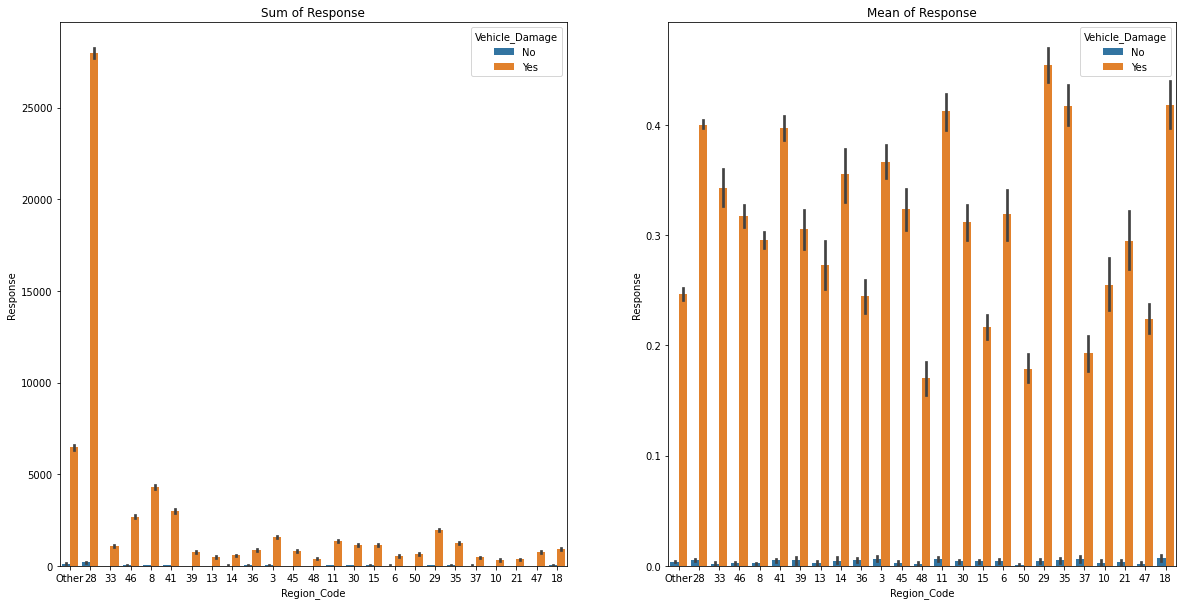

In [46]:
# Bivariate bar plot of 'Region_Code', 'Response' and 'Vehicle_Damage'

bivariate_sum_mean_var_plot(df_train_drop, 'Region_Code', 'Response', 'Vehicle_Damage')

Insurance purchasing volume and likelihood of customers who doesn't have any vehicle damage is negligible/insignificant when compared with the customers with the damaged category. This is consistent across all regions.

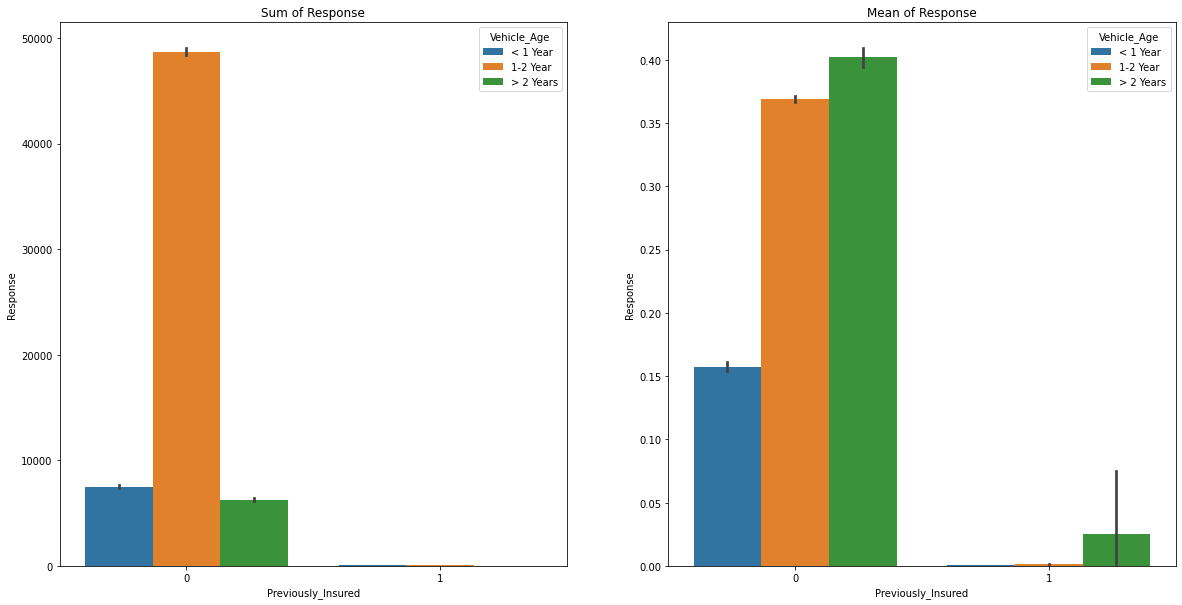

In [47]:
# Bivariate bar plot of 'Previously_Insured', 'Response' and 'Vehicle_Age'

bivariate_sum_mean_var_plot(df_train_drop, 'Previously_Insured', 'Response', 'Vehicle_Age')

Customers who doesn't have insurance in the past and with vehicle age ``1-2 Year`` have made the highest insurance purchases. Customers who doesn't have insurance in the past and with vehicle age ``> 2 Years`` have made the least insurance purchases but the likelihood of these customers to opt for insurance is the highest.

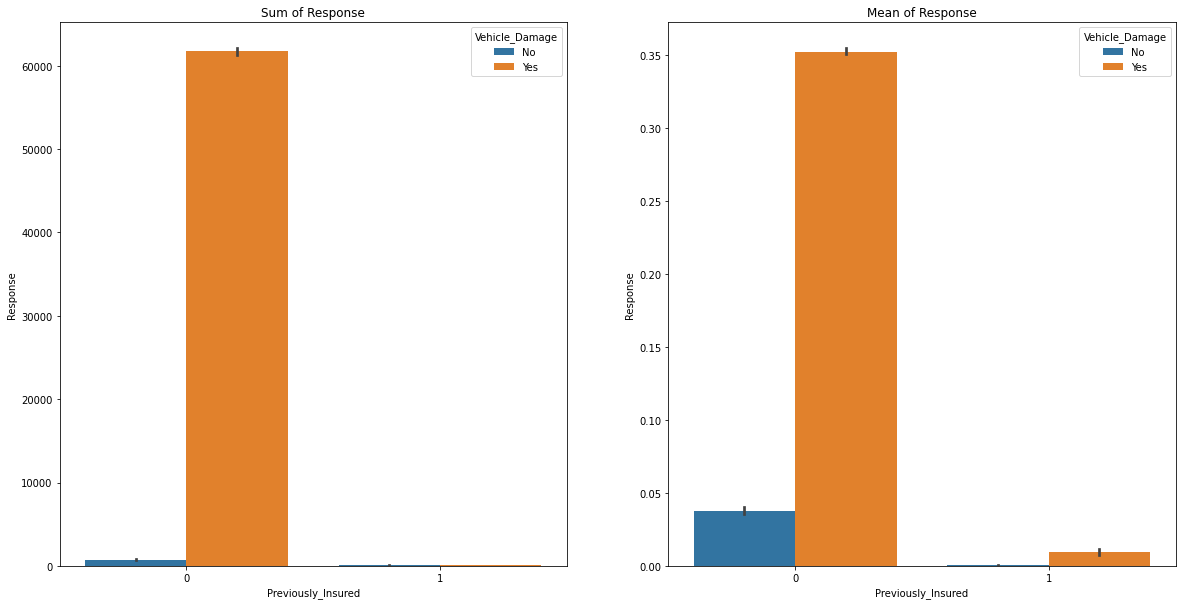

In [48]:
# Bivariate bar plot of 'Previously_Insured', 'Response' and 'Vehicle_Damage'

bivariate_sum_mean_var_plot(df_train_drop, 'Previously_Insured', 'Response', 'Vehicle_Damage')

Customers who have vehicle damage in the past and with no previous insurance have made the highest insurance purchases and are more likely to opt for insurance.

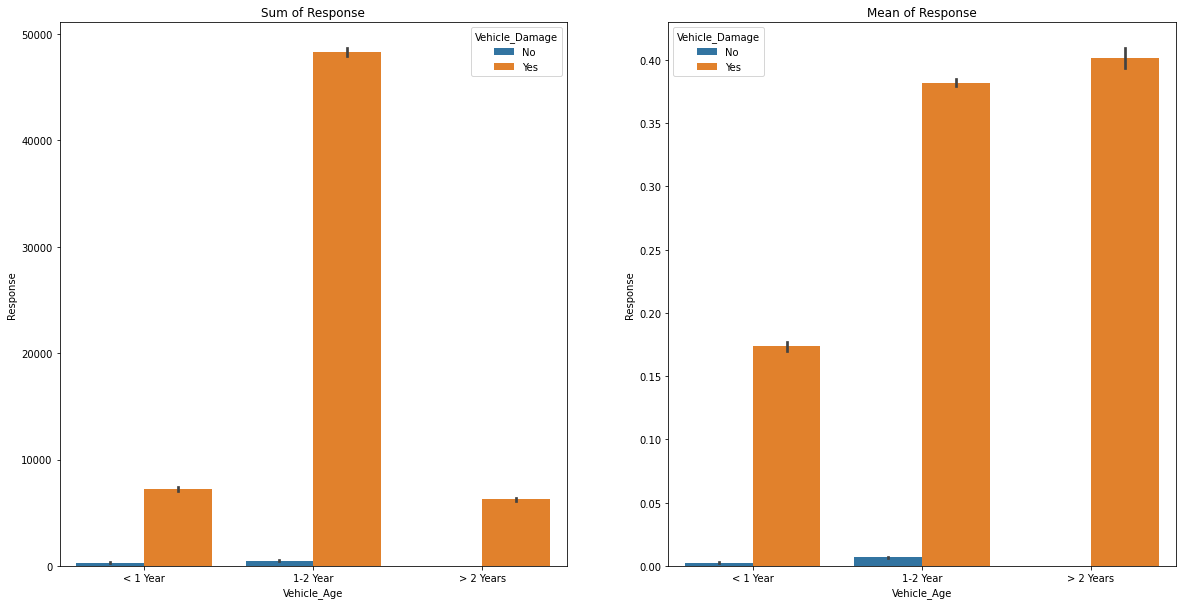

In [49]:
# Bivariate bar plot of 'Vehicle_Age', 'Response' and 'Vehicle_Damage'

bivariate_sum_mean_var_plot(df_train_drop, 'Vehicle_Age', 'Response', 'Vehicle_Damage')

Customers with vehicle damage and with vehicle age ``1-2 Year`` have made the highest insurance purchases. Customers with vehicle age ``> 2 Years`` have made the least insurance purchases but the likelihood of these customers to opt for insurance is the highest.

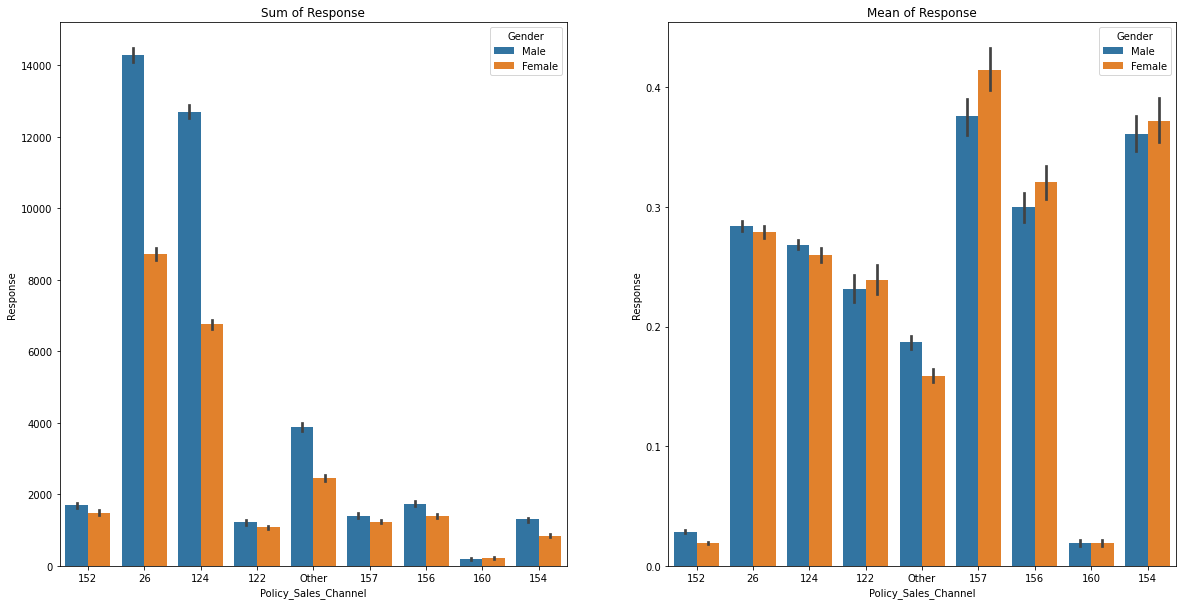

In [50]:
# Bivariate bar plot of 'Policy_Sales_Channel', 'Response' and 'Gender'

bivariate_sum_mean_var_plot(df_train_drop, 'Policy_Sales_Channel', 'Response', 'Gender')

- ``Male`` customer has purchased significantly more insurances than the ``Female`` customers through channels ``26`` and ``124``, but the difference in the purchasing volumns of Male and Female customers through rest of the channels is very small or not significant.
- Eventhough Male customers have higher insurance purchases through channels ``122``, ``157``, ``156`` and ``154``, likelihood of female customers opting for insurance is higher than male customers.
- The difference in the likelihood of Male and Female customers opting for insurance through rest of the channels is very small or not significant.

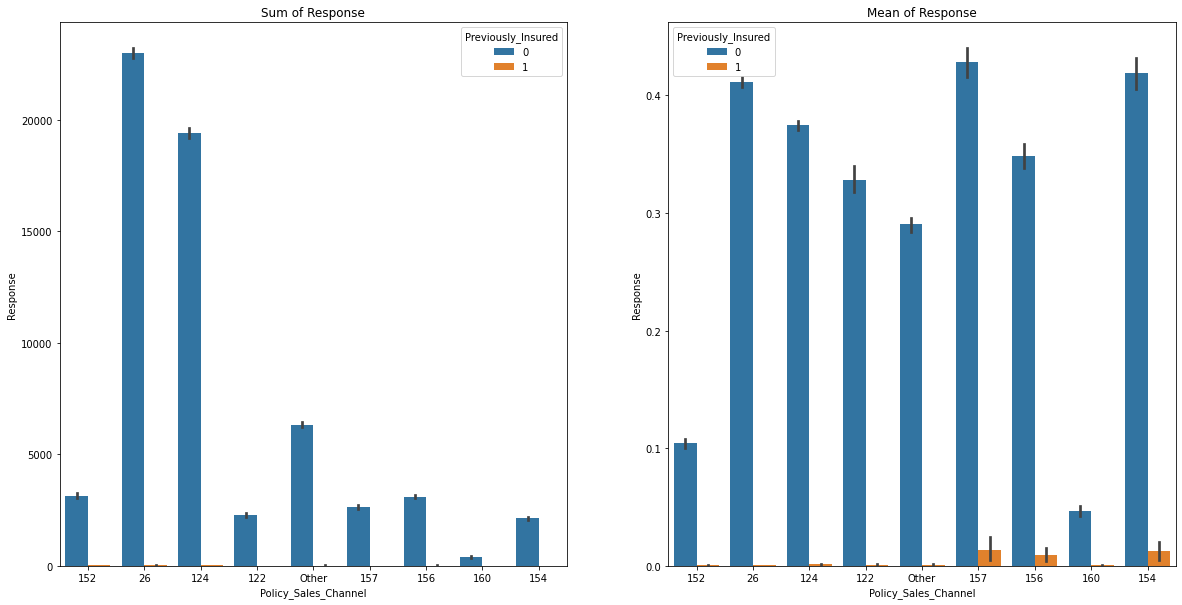

In [51]:
# Bivariate bar plot of 'Policy_Sales_Channel', 'Response' and 'Previously_Insured'

bivariate_sum_mean_var_plot(df_train_drop, 'Policy_Sales_Channel', 'Response', 'Previously_Insured')

Insurance purchasing volume and likelihood of customers who have insurance is negligible/insignificant when compared with the customers with the No previous insurance category. This is consistent across all channels.

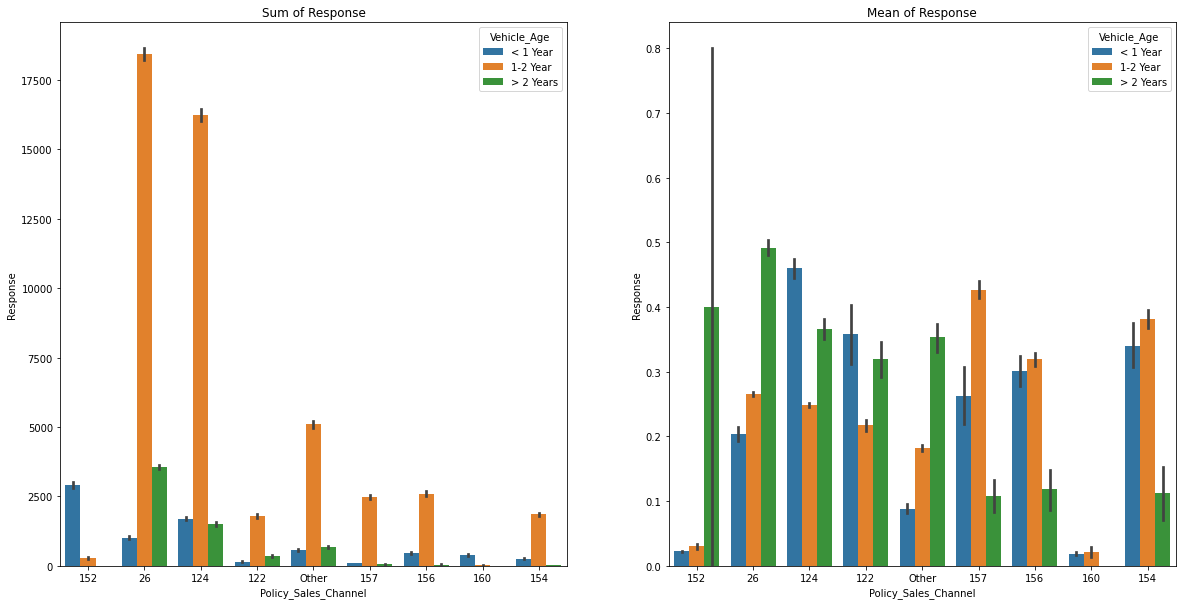

In [52]:
# Bivariate bar plot of 'Policy_Sales_Channel', 'Response' and 'Vehicle_Age'

bivariate_sum_mean_var_plot(df_train_drop, 'Policy_Sales_Channel', 'Response', 'Vehicle_Age')

- Customers with vehicle age ``1-2 Year`` have made more insurance purchases through all channels except for channels ``152`` and ``160`` where customers with vehicle age ``< 1 Year`` made more insurance purchases but the likelihood of customers opting for insurace is difference based on the policy channel.
- Likelihood of customers opting for insurance with vehicle age ``< 1 Year`` is highest through channels ``124`` and ``122``, and through channels ``157``, ``156``, ``160`` and ``154``, likelihood of customers with vehicle age ``1-2 Year`` is highest. In the rest of the channels, customers with vehicle age ``> 2 Years`` are more likely to opt for insurance.

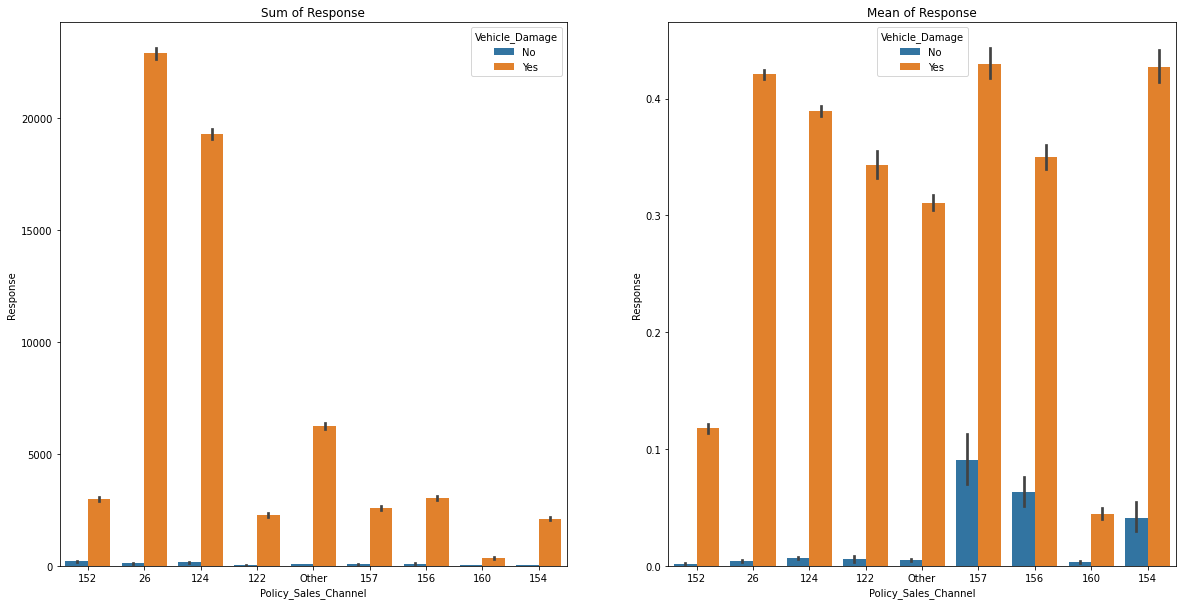

In [53]:
# Bivariate bar plot of 'Policy_Sales_Channel', 'Response' and 'Vehicle_Damage'

bivariate_sum_mean_var_plot(df_train_drop, 'Policy_Sales_Channel', 'Response', 'Vehicle_Damage')

Insurance purchasing volume and likelihood of customers who doesn't have any vehicle damage is negligible/insignificant when compared with the customers with the damaged category. This is consistent across all channels.

In [54]:
# Analysing 'Response' variable with 'Gender', 'Previously_Insured', 'Vehicle_Age' and 'Vehicle_Damage'

pd.pivot_table(data=df_train_drop, values=[ 'Response'], index='Vehicle_Age', 
               columns=['Previously_Insured', 'Vehicle_Damage', 'Gender'], aggfunc=[np.sum, np.mean]).round(2)

sum                                             \
                   Response                                              
Previously_Insured        0                         1                    
Vehicle_Damage           No         Yes            No         Yes        
Gender               Female Male Female   Male Female Male Female Male   
Vehicle_Age                                                              
1-2 Year                170  292  18587  29663     15   16     21   28   
< 1 Year                148  144   3205   3993     12   15     10   17   
> 2 Years                 0    0   2036   4228      0    0      0    1   

                       mean                                              
                   Response                                              
Previously_Insured        0                         1                    
Vehicle_Damage           No          Yes           No         Yes        
Gender               Female  Male Female  Male Female Male Female  Male  
Vehicle_Age                                                              
1-2 Year               0.04  0.05   0.40  0.40    0.0  0.0   0.01  0.01  
< 1 Year               0.03  0.04   0.16  0.22    0.0  0.0   0.01  0.01  
> 2 Years              0.00  0.00   0.37  0.42    0.0  0.0   0.00  0.05

- Insurance purchanses of customers who have previous insurance is very low/negligible across all ``Vehicle_Age`` categories and the likelihood of these customer opting for insurance is ``~0``.
- Customers who doesn't have previous insurance and with out ``Vehicle_Damage`` and with ``Vehicle_Age`` as ``> 2 Years`` have made 0 insurance purchases. Customers with ``Vehicle_Age`` as ``1-2 Year`` and ``< 1 Year`` have made less insurance purchases. The likelihood of customers with out insurance and vehicle damage opting for insurance is ``~0`` across all vehicle age categories.
- Customers with out previous insurance and with vehicle damage have contributed to majority of the insurance purchases. Male customers have made more insurance purchases than Female customers across all vehicle age categories. Customers with vehicle age ``1-2 Year`` have purchased huge number of insurances with significant number of insurance purchases coming from customers with vehicle age ``< 1 Year`` and ``> 2 Years``.
- Irrespective of Gender, customers with ``Vehicle_Age`` as ``1-2 Year`` and ``> 2 Years`` and customers with out previous insurance and with vehicle damage are most likely to purchase the insurance.

Now we know that, customers with out previous insurance and with vehicle damage have made more insurance purchases across all categories, these customers will be our focus group to analyse the Continuous variables.

In [55]:
# Analysing Continuous variables with focus group customers

focus_group_df = df_train_drop[df_train_drop['Previously_Insured']==0][df_train_drop['Vehicle_Damage']=='Yes']

pd.pivot_table(data=focus_group_df, values=['Age', 'Annual_Premium'], index='Vehicle_Age', columns=['Gender'], 
               aggfunc=[np.mean, np.median]).round(2)

mean                                 median                      \
               Age        Annual_Premium              Age      Annual_Premium   
Gender      Female   Male         Female      Male Female Male         Female   
Vehicle_Age                                                                     
1-2 Year     46.84  47.55       31125.04  30705.88     45   46        33056.5   
< 1 Year     24.65  25.17       29711.63  29831.12     24   24        30802.5   
> 2 Years    54.17  54.34       36709.08  35976.41     52   53        38277.5   

                      
                      
Gender          Male  
Vehicle_Age           
1-2 Year     32696.0  
< 1 Year     31153.5  
> 2 Years    37706.0

- Customer with vehicle age ``1-2 Year`` and with out previous insurance and with vehicle damage falling in the age bracket of 44-49 are more likely to opt for insurance with 30000 to 35000 annual premium. 
- Customers with vehicle age ``> 2 Years`` falling in the age bracket of 51-55 are more likely to opt for insurance with slightly higher premiums (35000 to 40000) as they are more likely to earn higher income and age of vehicle can also be a factor for higher premiums. 

## **5. Data Preparation**

In [23]:
# map 'Gender' and 'Vehicle_Damage' column values to 0 and 1

df_train_map = df_train_drop.replace({'Male':0, 'Female':1, 'No':0, 'Yes':1 })
df_train_map.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,22,Other,1,< 1 Year,0,2630.0,152,16,0
1,0,42,28,0,1-2 Year,1,43327.0,26,135,0
2,1,66,33,0,1-2 Year,1,35841.0,124,253,0
3,1,22,33,0,< 1 Year,0,27645.0,152,69,0
4,0,28,46,1,< 1 Year,0,29023.0,152,211,0


In [24]:
# Function to create dummies

def create_dummies(df, var1, var2='', drop_First=False):
    if drop_First:
        dummies = pd.get_dummies(df[var1], drop_first=True)
    else:
        dummies = pd.get_dummies(df[var1], prefix=var1)
        dummies.drop(columns=[var1+'_'+var2], inplace=True)
        
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=var1, inplace=True)
    return df

In [25]:
# Create dummy variables

df_train_model = create_dummies(df_train_map, 'Vehicle_Age', drop_First=True)
df_train_model = create_dummies(df_train_model, 'Region_Code', 'Other')
df_train_model = create_dummies(df_train_model, 'Policy_Sales_Channel', 'Other')
df_train_model.shape

(382154, 41)

In [26]:
# Rename columns

df_train_model.rename(columns={'< 1 Year': 'Less_than_1_year', '> 2 Years': 'More_than_2_years'}, inplace=True)
# df_train_model.to_excel('Org_modelling_data.xlsx', index=False)
df_train_model.shape

(382154, 41)

In [60]:
''' The cell is executed only once in the entire implementation phase. On every execution, this cell returns a different sample 
 of datasets which will have ripple effect on all the results. Hence, the code is commented to ensure the reproducibility of 
 results.'''

# Sample 10%, 20% and 40% of data and save to excel

# df_10_org = df_train_model.groupby('Response', group_keys=False).apply(lambda x : x.sample(frac=0.1))
# df_10_org.to_excel('10_modelling_data.xlsx', index=True)

# df_20_org = df_train_model.groupby('Response', group_keys=False).apply(lambda x : x.sample(frac=0.2))
# df_20_org.to_excel('20_modelling_data.xlsx', index=True)

# df_40_org = df_train_model.groupby('Response', group_keys=False).apply(lambda x : x.sample(frac=0.4))
# df_40_org.to_excel('40_modelling_data.xlsx', index=True)

# print(df_train_model.shape, df_10_org.shape, df_20_org.shape, df_40_org.shape)
# print(sum(df_train_model['Response']), sum(df_10_org['Response']), sum(df_20_org['Response']), sum(df_40_org['Response']))
# sum(df_train_model['Response'])/len(df_train_model), sum(df_10_org['Response'])/len(df_10_org), sum(df_20_org['Response'])/len(df_20_org), sum(df_40_org['Response'])/len(df_40_org)

' The cell is executed only once in the entire implementation phase. On every execution, this cell returns a different sample \n of datasets which will have ripple effect on all the results. Hence, the code is commented to ensure the reproducibility of \n results.'

## **6. Data Modelling**

In [27]:
md_data = df_train_model.copy()
md_data.head()

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response,Less_than_1_year,More_than_2_years,Region_Code_10,...,Region_Code_6,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26
0,0,22,1,0,2630.0,16,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,42,0,1,43327.0,135,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,66,0,1,35841.0,253,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,22,0,0,27645.0,69,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,28,1,0,29023.0,211,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


<AxesSubplot:>

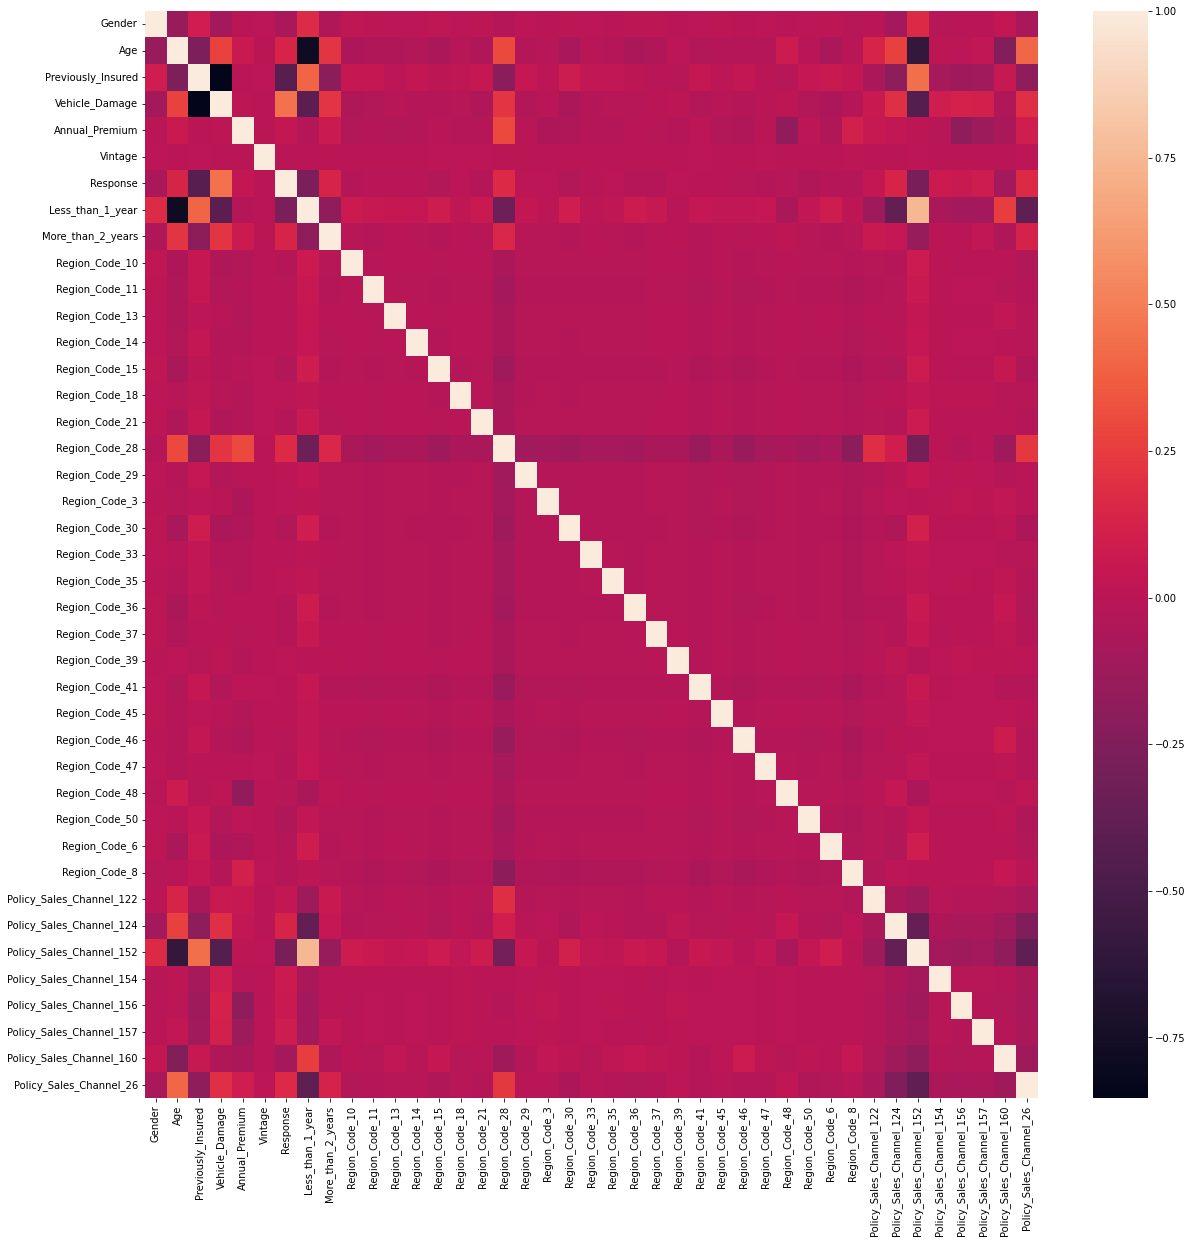

In [28]:
# correlation plot

plt.figure(figsize=(20,20))
sns.heatmap(md_data.corr())

In [29]:
# Reusable Functions

def normalize_train_test_split(df, cont_vars, return_balanced_data=False):
    
    y = df.pop('Response')
    
    lr_X_train, lr_X_val, lr_y_train, lr_y_val = model_selection.train_test_split(df, y, train_size=0.7, random_state=42, stratify=y)
    print(lr_X_train.shape, lr_X_val.shape, sum(lr_y_train)/len(lr_y_train), sum(lr_y_val)/len(lr_y_val))

    # normalize continuous variables

    scaler = preprocessing.StandardScaler()
    lr_X_train[cont_vars] = scaler.fit_transform(lr_X_train[cont_vars])
    lr_X_val[cont_vars] = scaler.transform(lr_X_val[cont_vars])
    
#     Prepare independent and dependent variables

#     lr_y_train = lr_X_train.pop('Response')
#     lr_X_train = lr_X_train
#     lr_y_val = lr_X_val.pop('Response')
#     lr_X_val = lr_X_val
    
    # Balance the imbalance data
    
    if return_balanced_data:
        ada = ADASYN(random_state=42, n_jobs=-1)
        smo = SMOTE(random_state=42, n_jobs=-1)
        lr_X_train_ada, lr_y_train_ada = ada.fit_resample(lr_X_train, lr_y_train)
        lr_X_train_smote, lr_y_train_smote = smo.fit_resample(lr_X_train, lr_y_train)
    print(lr_X_train.shape, lr_y_train.shape, lr_X_train_ada.shape, lr_y_train_ada.shape, lr_X_train_smote.shape, lr_y_train_smote.shape, lr_X_val.shape, lr_y_val.shape)
    return lr_X_train, lr_y_train, lr_X_train_ada, lr_y_train_ada, lr_X_train_smote, lr_y_train_smote, lr_X_val, lr_y_val

def rfe_feature_selection(model_obj, train_df_X, train_df_y, col_num):
    
    rfe = feature_selection.RFE(estimator=model_obj, n_features_to_select=col_num)
    rfe = rfe.fit(train_df_X, train_df_y)

    col = list(train_df_X.columns[rfe.support_])
    print(len(col))
    return col

# functions to fit the model, calculate accuracy and vif

def run_statsmodel(df_X, df_y):
    X_train_rfe = sm.add_constant(df_X)
    lm = sm.GLM(df_y, X_train_rfe, family=sm.families.Binomial()).fit()
    return lm.summary(), lm

def calculate_accuracy(lm, var_list, df, labels):
    lr_y_train_pred = lm.predict(sm.add_constant(df[var_list])).values.reshape(-1)
    df = pd.DataFrame()
    df['Converted'] = labels.values
    df['Conv_Prob'] = lr_y_train_pred
    df['Predicted'] = df['Conv_Prob'].apply(lambda x : 1 if x > 0.5 else 0)
    cm = metrics.confusion_matrix(df['Converted'], df['Predicted'])
    accuracy = metrics.accuracy_score(df['Converted'], df['Predicted'])
    return df, cm, round(accuracy, 3)

def calculate_VIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [round(variance_inflation_factor(df.values, i),2) for i in range(df.shape[1])]
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def calculate_accuracy_vif(trained_model, col_list, train_df, labels):
    y_train_pred, cm_matrix, model_accuracy = calculate_accuracy(trained_model, col_list, train_df, labels)
    print(f'Accuracy of Model is {model_accuracy}')
    VIF_df = calculate_VIF(train_df[col_list])
    print(cm_matrix)
    return y_train_pred, cm_matrix, VIF_df

def calculate_oprimal_threshold(fpr, tpr, thresholds):
    df_roc = pd.DataFrame()
    df_roc['thresholds'] = thresholds
    df_roc['tpr'] = tpr
    df_roc['fpr'] = fpr
    df_roc['spec'] = 1-fpr
    df_roc['diff'] = np.abs(df_roc['tpr']-df_roc['spec'])
    df_roc = df_roc.sort_values('diff')
    return df_roc 
    
def evaluate_model(df, pred, train=True):
    cm = metrics.confusion_matrix(df['Converted'], df[pred])
    TP = cm[1,1] # True Positive
    TN = cm[0,0] # True Negative
    FP = cm[0,1] # False Positive
    FN = cm[1,0] # False Negative
    acc = round(metrics.accuracy_score(df['Converted'], df[pred]), 3)
    rv = round(metrics.recall_score(df['Converted'], df[pred]), 3)
    pv = round(metrics.precision_score(df['Converted'], df[pred]), 3)
    f1 = round(metrics.f1_score(df['Converted'], df[pred]), 3)
    auc = round(metrics.roc_auc_score(df['Converted'], df['Conv_Prob']), 3)
    sv = round(TN / float(TN+FP), 3)
    g_mean = round(np.sqrt(rv*sv), 3)
    print_str = f'Accuracy: {acc}, Recall: {rv}, Precision: {pv}, F1-score: {f1}, AUC: {auc}, Specificity: {sv}, G-Mean: {g_mean}'
    if train:
        fpr, tpr, thresholds = metrics.roc_curve(df['Converted'], df['Conv_Prob'])
        df_roc = calculate_oprimal_threshold(fpr, tpr, thresholds)
        print(df_roc.head())
        opt_threshold = round(df_roc.iloc[0]['thresholds'], 2)
        print_str += f', Optimal Threshold: {opt_threshold}'
        print(print_str)
        return fpr, tpr, thresholds, opt_threshold
    else:
        print(print_str)
    
    
def calculate_labels_at_diff_thresholds(df):  
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df[i]= df['Conv_Prob'].map(lambda x: 1 if x > i else 0)

    cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

    for i in numbers:
        cm1 = metrics.confusion_matrix(df['Converted'], df[i])
        accuracy = metrics.accuracy_score(df['Converted'], df[i])
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[int(i*10)] =[i ,accuracy,sensi,speci]
    return cutoff_df

def evaluate_model_on_test_data(mdl_obj, val_x, cols_list, val_y, threshold_val):
    y_test_pred = mdl_obj.predict(sm.add_constant(val_x[cols_list]))
    y_test_pred_final = pd.DataFrame()
    y_test_pred_final['Converted'] = val_y
    y_test_pred_final['Conv_Prob'] = y_test_pred
    y_test_pred_final['final_predicted'] = y_test_pred_final.Conv_Prob.map(lambda x: 1 if x > threshold_val else 0)
    evaluate_model(y_test_pred_final, pred='final_predicted', train=False)

In [30]:
%%time
# Split the data

lr_X_train, lr_y_train, lr_X_train_ada, lr_y_train_ada, lr_X_train_smote, lr_y_train_smote, lr_X_val, lr_y_val = normalize_train_test_split(md_data, cont_vars, return_balanced_data=True)

(267507, 40) (114647, 40) 0.16381253574672813 0.16380716460090539
(267507, 40) (267507,) (440827, 40) (440827,) (447372, 40) (447372,) (114647, 40) (114647,)
Wall time: 11min 33s


In [31]:
# Train data

lr_X_train_gan = lr_X_train.copy()
lr_X_train_gan['Response'] = lr_y_train.copy()
lr_X_train_gan

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
2808,1,0.030816,1,0,-0.261704,0.083262,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169115,0,0.359305,0,1,0.265857,0.310192,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
238016,0,-0.823256,0,1,-0.215056,0.931262,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
38505,0,1.476168,1,0,-0.060033,1.540388,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
185395,1,0.359305,1,0,-1.652374,-0.394484,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147819,1,0.293607,0,1,0.409806,1.110417,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
174620,1,0.884888,1,0,-0.045603,-1.075273,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
363974,1,-1.020349,1,0,0.328761,-1.672456,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
379889,0,0.687794,1,0,0.506519,0.907375,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [32]:
# load minority class synthetic samples generated by GAN

gan_data = pd.read_excel('20220818061858641143cp_syn_data_1_train.xlsx')[lr_X_train_gan.columns] #20220804060006139609cp_syn_data_1_train
gan_data

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
0,0,48,0,1,41244,293,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,38,0,1,34508,298,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,64,0,1,2630,215,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,40,0,1,42697,268,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,56,0,1,2630,151,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223681,1,50,0,1,73758,87,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223682,0,55,0,1,30206,169,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
223683,1,43,0,1,22859,23,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
223684,0,39,0,1,27195,226,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [33]:
# Balance the train data

scaler = preprocessing.StandardScaler()
gan_data[cont_vars] = scaler.fit_transform(gan_data[cont_vars])
lr_X_train_gan_bal = pd.concat([lr_X_train_gan, gan_data])
lr_X_train_gan_bal

,Gender,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Less_than_1_year,More_than_2_years,Region_Code_10,Region_Code_11,...,Region_Code_8,Policy_Sales_Channel_122,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Policy_Sales_Channel_154,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Response
2808,1,0.030816,1,0,-0.261704,0.083262,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169115,0,0.359305,0,1,0.265857,0.310192,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
238016,0,-0.823256,0,1,-0.215056,0.931262,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
38505,0,1.476168,1,0,-0.060033,1.540388,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
185395,1,0.359305,1,0,-1.652374,-0.394484,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223681,1,0.250294,0,1,2.138618,-0.872610,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
223682,0,0.613402,0,1,-0.100264,0.121321,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
223683,1,-0.258056,0,1,-0.477952,-1.648361,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
223684,0,-0.548542,0,1,-0.255051,0.812224,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [34]:
# prepare X_train and y_train

lr_y_train_gan_bal = lr_X_train_gan_bal.pop('Response')
lr_X_train_gan_bal = lr_X_train_gan_bal

### 6.1. GLM - Imbalanced Data

In [69]:
# Automated feature selection

logreg_rfe = linear_model.LogisticRegression()
logreg_rfe.fit(lr_X_train, lr_y_train)
col = rfe_feature_selection(logreg_rfe, lr_X_train, lr_y_train, 15)

15


In [70]:
# Fit model with 15 cols

col_1 = col.copy()
mod_1, lm_1 = run_statsmodel(lr_X_train[col_1], lr_y_train)
mod_1

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               267507
Model:                            GLM   Df Residuals:                   267491
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76013.
Date:                Thu, 25 Aug 2022   Deviance:                   1.5203e+05
Time:                        09:41:43   Pearson chi2:                 2.62e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2764
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.6865      0.045    -59.454      0.000      -2.775      -2.598
Age                         -0.5799      0.010    -60.486      0.000      -0.599      -0.561
Previously_Insured          -4.1498      0.105    -39.560      0.000      -4.355      -3.944
Vehicle_Damage               2.4659      0.045     54.905      0.000       2.378       2.554
Less_than_1_year            -0.7211      0.026    -27.375      0.000      -0.773      -0.669
Region_Code_11               0.4148      0.045      9.221      0.000       0.327       0.503
Region_Code_18               0.4291      0.054      7.971      0.000       0.324       0.535
Region_Code_29               0.3886      0.038     10.124      0.000       0.313       0.464
Region_Code_3                0.2365      0.041      5.790      0.000       0.156       0.317
Region_Code_35               0.3813      0.048      7.951      0.000       0.287       0.475
Region_Code_41               0.3140      0.031     10.204      0.000       0.254       0.374
Region_Code_48              -0.9060      0.066    -13.829      0.000      -1.034      -0.778
Region_Code_50              -0.6701      0.054    -12.372      0.000      -0.776      -0.564
Policy_Sales_Channel_152    -1.5191      0.031    -48.947      0.000      -1.580      -1.458
Policy_Sales_Channel_160    -2.5181      0.065    -38.643      0.000      -2.646      -2.390
Policy_Sales_Channel_26      0.3750      0.014     27.207      0.000       0.348       0.402
============================================================================================
"""

In [71]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1, lr_cm_1, lr_VIF_1 = calculate_accuracy_vif(lm_1, col_1, lr_X_train, lr_y_train)
lr_VIF_1

Accuracy of Model is 0.835
[[215236   8450]
 [ 35618   8203]]


,Features,VIF
3,Less_than_1_year,8.19
12,Policy_Sales_Channel_152,5.97
1,Previously_Insured,2.96
0,Age,2.59
2,Vehicle_Damage,1.84
13,Policy_Sales_Channel_160,1.76
14,Policy_Sales_Channel_26,1.55
9,Region_Code_41,1.07
4,Region_Code_11,1.04
6,Region_Code_29,1.04


In [72]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1.remove('Less_than_1_year')

col_2 = col_1.copy()
mod_2, lm_2 = run_statsmodel(lr_X_train[col_2], lr_y_train)
mod_2

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               267507
Model:                            GLM   Df Residuals:                   267492
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -76392.
Date:                Thu, 25 Aug 2022   Deviance:                   1.5278e+05
Time:                        09:41:55   Pearson chi2:                 2.59e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2744
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8184      0.045    -62.715      0.000      -2.906      -2.730
Age                         -0.4634      0.008    -54.947      0.000      -0.480      -0.447
Previously_Insured          -4.1579      0.105    -39.650      0.000      -4.363      -3.952
Vehicle_Damage               2.4923      0.045     55.544      0.000       2.404       2.580
Region_Code_11               0.4125      0.045      9.210      0.000       0.325       0.500
Region_Code_18               0.4257      0.054      7.938      0.000       0.321       0.531
Region_Code_29               0.4000      0.038     10.460      0.000       0.325       0.475
Region_Code_3                0.2328      0.041      5.718      0.000       0.153       0.313
Region_Code_35               0.3897      0.048      8.151      0.000       0.296       0.483
Region_Code_41               0.3130      0.031     10.203      0.000       0.253       0.373
Region_Code_48              -0.8873      0.065    -13.592      0.000      -1.015      -0.759
Region_Code_50              -0.6700      0.054    -12.400      0.000      -0.776      -0.564
Policy_Sales_Channel_152    -1.9849      0.026    -75.880      0.000      -2.036      -1.934
Policy_Sales_Channel_160    -2.9787      0.063    -47.264      0.000      -3.102      -2.855
Policy_Sales_Channel_26      0.3641      0.014     26.527      0.000       0.337       0.391
============================================================================================
"""

In [73]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2, lr_cm_2, lr_VIF_2 = calculate_accuracy_vif(lm_2, col_2, lr_X_train, lr_y_train)
lr_VIF_2

Accuracy of Model is 0.831
[[215672   8014]
 [ 37254   6567]]


,Features,VIF
11,Policy_Sales_Channel_152,3.34
1,Previously_Insured,2.69
0,Age,1.97
2,Vehicle_Damage,1.66
13,Policy_Sales_Channel_26,1.54
12,Policy_Sales_Channel_160,1.38
8,Region_Code_41,1.07
3,Region_Code_11,1.04
5,Region_Code_29,1.04
10,Region_Code_50,1.04


In [74]:
# Training predictions and Confusion matrix

train_pred_model = lm_2
train_cols = col_2
train_pred_df = lr_y_train_pred_final_2
train_pred_cm = lr_cm_2

In [75]:
# Evaluate model

fpr, tpr, thresholds, opt_threshold = evaluate_model(train_pred_df, pred='Predicted')

     thresholds       tpr       fpr      spec      diff
675    0.337310  0.818694  0.186650  0.813350  0.005344
676    0.337264  0.818740  0.186681  0.813319  0.005421
677    0.337192  0.818740  0.186695  0.813305  0.005435
674    0.337983  0.809041  0.182962  0.817038  0.007997
673    0.338259  0.809041  0.182931  0.817069  0.008028
Accuracy: 0.831, Recall: 0.15, Precision: 0.45, F1-score: 0.225, AUC: 0.882, Specificity: 0.964, G-Mean: 0.38, Optimal Threshold: 0.34


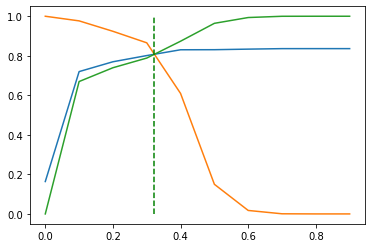

In [76]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df = calculate_labels_at_diff_thresholds(train_pred_df)
plt.plot(cutoff_df['prob'], cutoff_df['accuracy'])
plt.plot(cutoff_df['prob'], cutoff_df['sensi'])
plt.plot(cutoff_df['prob'], cutoff_df['speci'])
plt.vlines(x=.32, ymax=1, ymin=0, colors='g', linestyles='--')

In [77]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df['final_predicted'] = train_pred_df.Conv_Prob.map( lambda x: 1 if x > opt_threshold else 0)
evaluate_model(train_pred_df, pred='final_predicted')
train_pred_df.head()

     thresholds       tpr       fpr      spec      diff
675    0.337310  0.818694  0.186650  0.813350  0.005344
676    0.337264  0.818740  0.186681  0.813319  0.005421
677    0.337192  0.818740  0.186695  0.813305  0.005435
674    0.337983  0.809041  0.182962  0.817038  0.007997
673    0.338259  0.809041  0.182931  0.817069  0.008028
Accuracy: 0.816, Recall: 0.809, Precision: 0.464, F1-score: 0.59, AUC: 0.882, Specificity: 0.817, G-Mean: 0.813, Optimal Threshold: 0.34


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.000920,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.379272,0,1,1,1,1,0,0,0,0,0,0,1
2,0,0.051011,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.000678,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.001136,0,1,0,0,0,0,0,0,0,0,0,0


In [78]:
# making predictions on the test set

evaluate_model_on_test_data(train_pred_model, lr_X_val, train_cols, lr_y_val, opt_threshold)

Accuracy: 0.815, Recall: 0.806, Precision: 0.463, F1-score: 0.588, AUC: 0.881, Specificity: 0.817, G-Mean: 0.811


### 6.2. GLM - Balanced data - ADASYN

In [79]:
# Automated feature selection

logreg_rfe_ada = linear_model.LogisticRegression()
logreg_rfe_ada.fit(lr_X_train_ada, lr_y_train_ada)
col_ada = rfe_feature_selection(logreg_rfe_ada, lr_X_train_ada, lr_y_train_ada, 15)

15


In [80]:
# Fit model with 15 cols

col_1_ada = col_ada.copy()
mod_1_ada, lm_1_ada = run_statsmodel(lr_X_train_ada[col_1_ada], lr_y_train_ada)
mod_1_ada

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               440827
Model:                            GLM   Df Residuals:                   440811
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7081e+05
Date:                Thu, 25 Aug 2022   Deviance:                   3.4162e+05
Time:                        09:44:24   Pearson chi2:                 4.47e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4573
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.4386      0.019    -22.861      0.000      -0.476      -0.401
Age                         -0.5176      0.007    -78.417      0.000      -0.531      -0.505
Previously_Insured          -5.5457      0.078    -70.707      0.000      -5.699      -5.392
Vehicle_Damage               1.9759      0.019    103.595      0.000       1.939       2.013
Less_than_1_year            -0.6329      0.018    -34.291      0.000      -0.669      -0.597
Region_Code_10              -0.4023      0.055     -7.326      0.000      -0.510      -0.295
Region_Code_13              -0.4000      0.046     -8.777      0.000      -0.489      -0.311
Region_Code_15              -0.4205      0.027    -15.859      0.000      -0.472      -0.369
Region_Code_21              -0.3862      0.057     -6.826      0.000      -0.497      -0.275
Region_Code_37              -0.5066      0.041    -12.468      0.000      -0.586      -0.427
Region_Code_39              -0.4944      0.037    -13.471      0.000      -0.566      -0.422
Region_Code_47              -0.5682      0.032    -17.493      0.000      -0.632      -0.505
Region_Code_48              -0.8249      0.037    -22.040      0.000      -0.898      -0.752
Region_Code_50              -0.8656      0.032    -26.984      0.000      -0.928      -0.803
Policy_Sales_Channel_152    -1.2381      0.019    -65.466      0.000      -1.275      -1.201
Policy_Sales_Channel_160    -2.2541      0.031    -71.658      0.000      -2.316      -2.192
============================================================================================
"""

In [81]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_ada, lr_cm_1_ada, lr_VIF_1_ada = calculate_accuracy_vif(lm_1_ada, col_1_ada, lr_X_train_ada, lr_y_train_ada)
lr_VIF_1_ada

Accuracy of Model is 0.819
[[154559  69127]
 [ 10605 206536]]


,Features,VIF
3,Less_than_1_year,6.11
13,Policy_Sales_Channel_152,4.62
0,Age,2.25
1,Previously_Insured,2.19
2,Vehicle_Damage,1.67
14,Policy_Sales_Channel_160,1.54
6,Region_Code_15,1.04
12,Region_Code_50,1.03
4,Region_Code_10,1.02
7,Region_Code_21,1.02


In [82]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_ada.remove('Less_than_1_year')

col_2_ada = col_1_ada.copy()
mod_2_ada, lm_2_ada = run_statsmodel(lr_X_train_ada[col_2_ada], lr_y_train_ada)
mod_2_ada

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               440827
Model:                            GLM   Df Residuals:                   440812
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7137e+05
Date:                Thu, 25 Aug 2022   Deviance:                   3.4274e+05
Time:                        09:44:43   Pearson chi2:                 4.46e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4559
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.5557      0.019    -29.477      0.000      -0.593      -0.519
Age                         -0.4237      0.006    -70.820      0.000      -0.435      -0.412
Previously_Insured          -5.5484      0.078    -70.754      0.000      -5.702      -5.395
Vehicle_Damage               2.0004      0.019    105.084      0.000       1.963       2.038
Region_Code_10              -0.4162      0.055     -7.586      0.000      -0.524      -0.309
Region_Code_13              -0.4110      0.045     -9.036      0.000      -0.500      -0.322
Region_Code_15              -0.4155      0.027    -15.675      0.000      -0.468      -0.364
Region_Code_21              -0.3817      0.057     -6.741      0.000      -0.493      -0.271
Region_Code_37              -0.5238      0.041    -12.876      0.000      -0.603      -0.444
Region_Code_39              -0.4842      0.037    -13.242      0.000      -0.556      -0.412
Region_Code_47              -0.5739      0.032    -17.716      0.000      -0.637      -0.510
Region_Code_48              -0.8120      0.037    -21.792      0.000      -0.885      -0.739
Region_Code_50              -0.8582      0.032    -26.836      0.000      -0.921      -0.796
Policy_Sales_Channel_152    -1.6544      0.015   -110.163      0.000      -1.684      -1.625
Policy_Sales_Channel_160    -2.6694      0.029    -90.797      0.000      -2.727      -2.612
============================================================================================
"""

In [83]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_ada, lr_cm_2_ada, lr_VIF_2_ada = calculate_accuracy_vif(lm_2_ada, col_2_ada, lr_X_train_ada, lr_y_train_ada)
lr_VIF_2_ada

Accuracy of Model is 0.82
[[154475  69211]
 [ 10196 206945]]


,Features,VIF
12,Policy_Sales_Channel_152,2.73
1,Previously_Insured,2.02
0,Age,1.77
2,Vehicle_Damage,1.40
13,Policy_Sales_Channel_160,1.26
5,Region_Code_15,1.04
11,Region_Code_50,1.03
3,Region_Code_10,1.02
6,Region_Code_21,1.02
7,Region_Code_37,1.02


In [84]:
# Training predictions and Confusion matrix

train_pred_model_ada = lm_2_ada
train_cols_ada = col_2_ada
train_pred_df_ada = lr_y_train_pred_final_2_ada
train_pred_cm_ada = lr_cm_2_ada

In [85]:
# Evaluate model

fpr_ada, tpr_ada, thresholds_ada, opt_threshold_ada = evaluate_model(train_pred_df_ada, pred='Predicted')

     thresholds       tpr       fpr      spec      diff
460    0.699953  0.801065  0.198403  0.801597  0.000532
459    0.700223  0.800632  0.198403  0.801597  0.000965
458    0.700234  0.800609  0.198363  0.801637  0.001028
457    0.700367  0.800461  0.198363  0.801637  0.001176
456    0.700372  0.800222  0.198233  0.801767  0.001545
Accuracy: 0.82, Recall: 0.953, Precision: 0.749, F1-score: 0.839, AUC: 0.869, Specificity: 0.691, G-Mean: 0.811, Optimal Threshold: 0.7


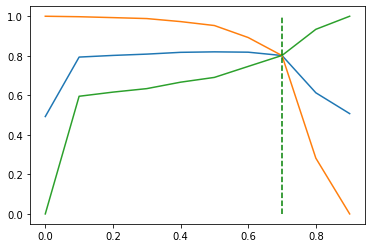

In [86]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_ada = calculate_labels_at_diff_thresholds(train_pred_df_ada)
plt.plot(cutoff_df_ada['prob'], cutoff_df_ada['accuracy'])
plt.plot(cutoff_df_ada['prob'], cutoff_df_ada['sensi'])
plt.plot(cutoff_df_ada['prob'], cutoff_df_ada['speci'])
plt.vlines(x=.7, ymax=1, ymin=0, colors='g', linestyles='--')

In [87]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_ada['final_predicted'] = train_pred_df_ada.Conv_Prob.map( lambda x: 1 if x > opt_threshold_ada else 0)
evaluate_model(train_pred_df_ada, pred='final_predicted')
train_pred_df_ada.head()

     thresholds       tpr       fpr      spec      diff
460    0.699953  0.801065  0.198403  0.801597  0.000532
459    0.700223  0.800632  0.198403  0.801597  0.000965
458    0.700234  0.800609  0.198363  0.801637  0.001028
457    0.700367  0.800461  0.198363  0.801637  0.001176
456    0.700372  0.800222  0.198233  0.801767  0.001545
Accuracy: 0.801, Recall: 0.801, Precision: 0.797, F1-score: 0.799, AUC: 0.869, Specificity: 0.802, G-Mean: 0.801, Optimal Threshold: 0.7


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.002200,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.784558,1,1,1,1,1,1,1,1,1,0,0,1
2,0,0.294027,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.001194,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.001915,0,1,0,0,0,0,0,0,0,0,0,0


In [88]:
# making predictions on the test set

evaluate_model_on_test_data(train_pred_model_ada, lr_X_val, train_cols_ada, lr_y_val, opt_threshold_ada)

Accuracy: 0.807, Recall: 0.832, Precision: 0.451, F1-score: 0.585, AUC: 0.877, Specificity: 0.802, G-Mean: 0.817


### 6.3. GLM - Balanced data - SMOTE

In [89]:
# Automated feature selection

logreg_rfe_smt = linear_model.LogisticRegression()
logreg_rfe_smt.fit(lr_X_train_smote, lr_y_train_smote)
col_smt = rfe_feature_selection(logreg_rfe_smt, lr_X_train_smote, lr_y_train_smote, 15)

15


In [90]:
# Fit model with 15 cols

col_1_smt = col_smt.copy()
mod_1_smt, lm_1_smt = run_statsmodel(lr_X_train_smote[col_1_smt], lr_y_train_smote)
mod_1_smt

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               447372
Model:                            GLM   Df Residuals:                   447356
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6576e+05
Date:                Thu, 25 Aug 2022   Deviance:                   3.3151e+05
Time:                        09:47:19   Pearson chi2:                 5.00e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4755
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.7703      0.022    -34.810      0.000      -0.814      -0.727
Age                         -0.7008      0.007   -100.425      0.000      -0.715      -0.687
Previously_Insured          -5.5093      0.087    -63.507      0.000      -5.679      -5.339
Vehicle_Damage               2.3157      0.022    105.393      0.000       2.273       2.359
Less_than_1_year            -0.7974      0.019    -42.958      0.000      -0.834      -0.761
Region_Code_10              -0.5240      0.059     -8.932      0.000      -0.639      -0.409
Region_Code_15              -0.4258      0.028    -15.318      0.000      -0.480      -0.371
Region_Code_21              -0.4060      0.059     -6.873      0.000      -0.522      -0.290
Region_Code_37              -0.5737      0.044    -13.177      0.000      -0.659      -0.488
Region_Code_39              -0.5034      0.038    -13.359      0.000      -0.577      -0.430
Region_Code_47              -0.6014      0.034    -17.721      0.000      -0.668      -0.535
Region_Code_48              -1.0166      0.040    -25.378      0.000      -1.095      -0.938
Region_Code_50              -0.9728      0.034    -28.304      0.000      -1.040      -0.905
Policy_Sales_Channel_152    -1.5458      0.020    -78.298      0.000      -1.584      -1.507
Policy_Sales_Channel_160    -2.6673      0.035    -75.546      0.000      -2.737      -2.598
Policy_Sales_Channel_26      0.3754      0.010     37.932      0.000       0.356       0.395
============================================================================================
"""

In [91]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_smt, lr_cm_1_smt, lr_VIF_1_smt = calculate_accuracy_vif(lm_1_smt, col_1_smt, lr_X_train_smote, lr_y_train_smote)
lr_VIF_1_smt

Accuracy of Model is 0.833
[[164708  58978]
 [ 15810 207876]]


,Features,VIF
3,Less_than_1_year,5.82
12,Policy_Sales_Channel_152,4.55
1,Previously_Insured,2.34
0,Age,2.30
2,Vehicle_Damage,1.97
14,Policy_Sales_Channel_26,1.64
13,Policy_Sales_Channel_160,1.52
5,Region_Code_15,1.04
11,Region_Code_50,1.03
4,Region_Code_10,1.02


In [92]:
# fit the model with out 'Less_than_1_year' as is has high vif value

col_1_smt.remove('Less_than_1_year')

col_2_smt = col_1_smt.copy()
mod_2_smt, lm_2_smt = run_statsmodel(lr_X_train_smote[col_2_smt], lr_y_train_smote)
mod_2_smt

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               447372
Model:                            GLM   Df Residuals:                   447357
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6662e+05
Date:                Thu, 25 Aug 2022   Deviance:                   3.3325e+05
Time:                        09:47:39   Pearson chi2:                 4.98e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4734
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9130      0.022    -41.814      0.000      -0.956      -0.870
Age                         -0.5831      0.006    -91.540      0.000      -0.596      -0.571
Previously_Insured          -5.5198      0.087    -63.638      0.000      -5.690      -5.350
Vehicle_Damage               2.3471      0.022    107.089      0.000       2.304       2.390
Region_Code_10              -0.5426      0.059     -9.256      0.000      -0.658      -0.428
Region_Code_15              -0.4133      0.028    -14.902      0.000      -0.468      -0.359
Region_Code_21              -0.4010      0.059     -6.781      0.000      -0.517      -0.285
Region_Code_37              -0.5905      0.044    -13.558      0.000      -0.676      -0.505
Region_Code_39              -0.4869      0.037    -12.996      0.000      -0.560      -0.413
Region_Code_47              -0.6011      0.034    -17.797      0.000      -0.667      -0.535
Region_Code_48              -1.0023      0.040    -25.191      0.000      -1.080      -0.924
Region_Code_50              -0.9666      0.034    -28.251      0.000      -1.034      -0.900
Policy_Sales_Channel_152    -2.0772      0.016   -128.934      0.000      -2.109      -2.046
Policy_Sales_Channel_160    -3.1986      0.034    -95.411      0.000      -3.264      -3.133
Policy_Sales_Channel_26      0.3697      0.010     37.508      0.000       0.350       0.389
============================================================================================
"""

In [93]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_smt, lr_cm_2_smt, lr_VIF_2_smt = calculate_accuracy_vif(lm_2_smt, col_2_smt, lr_X_train_smote, lr_y_train_smote)
lr_VIF_2_smt

Accuracy of Model is 0.833
[[164147  59539]
 [ 15387 208299]]


,Features,VIF
11,Policy_Sales_Channel_152,2.76
1,Previously_Insured,2.19
0,Age,1.82
2,Vehicle_Damage,1.75
13,Policy_Sales_Channel_26,1.63
12,Policy_Sales_Channel_160,1.26
4,Region_Code_15,1.04
10,Region_Code_50,1.03
3,Region_Code_10,1.02
5,Region_Code_21,1.02


In [94]:
# Training predictions and Confusion matrix

train_pred_model_smt = lm_2_smt
train_cols_smt = col_2_smt
train_pred_df_smt = lr_y_train_pred_final_2_smt
train_pred_cm_smt = lr_cm_2_smt

In [95]:
# Evaluate model

fpr_smt, tpr_smt, thresholds_smt, opt_threshold_smt = evaluate_model(train_pred_df_smt, pred='Predicted')

     thresholds       tpr       fpr      spec      diff
749    0.711941  0.816041  0.183699  0.816301  0.000259
750    0.711420  0.816645  0.183699  0.816301  0.000344
751    0.711418  0.816676  0.183735  0.816265  0.000411
752    0.711014  0.817221  0.183735  0.816265  0.000957
753    0.711005  0.817266  0.183758  0.816242  0.001024
Accuracy: 0.833, Recall: 0.931, Precision: 0.778, F1-score: 0.848, AUC: 0.883, Specificity: 0.734, G-Mean: 0.827, Optimal Threshold: 0.71


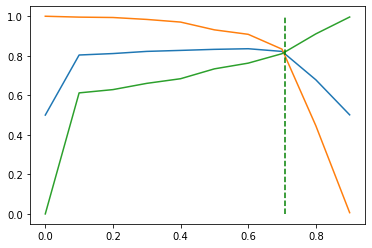

In [96]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_smt = calculate_labels_at_diff_thresholds(train_pred_df_smt)
plt.plot(cutoff_df_smt['prob'], cutoff_df_smt['accuracy'])
plt.plot(cutoff_df_smt['prob'], cutoff_df_smt['sensi'])
plt.plot(cutoff_df_smt['prob'], cutoff_df_smt['speci'])
plt.vlines(x=.71, ymax=1, ymin=0, colors='g', linestyles='--')

In [97]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_smt['final_predicted'] = train_pred_df_smt.Conv_Prob.map( lambda x: 1 if x > opt_threshold_smt else 0)
evaluate_model(train_pred_df_smt, pred='final_predicted')
train_pred_df_smt.head()

     thresholds       tpr       fpr      spec      diff
749    0.711941  0.816041  0.183699  0.816301  0.000259
750    0.711420  0.816645  0.183699  0.816301  0.000344
751    0.711418  0.816676  0.183735  0.816265  0.000411
752    0.711014  0.817221  0.183735  0.816265  0.000957
753    0.711005  0.817266  0.183758  0.816242  0.001024
Accuracy: 0.817, Recall: 0.818, Precision: 0.817, F1-score: 0.818, AUC: 0.883, Specificity: 0.816, G-Mean: 0.817, Optimal Threshold: 0.71


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.001577,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.772886,1,1,1,1,1,1,1,1,1,0,0,1
2,0,0.216794,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.000983,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.001884,0,1,0,0,0,0,0,0,0,0,0,0


In [98]:
# making predictions on the test set

evaluate_model_on_test_data(train_pred_model_smt, lr_X_val, train_cols_smt, lr_y_val, opt_threshold_smt)

Accuracy: 0.814, Recall: 0.803, Precision: 0.461, F1-score: 0.586, AUC: 0.879, Specificity: 0.816, G-Mean: 0.809


### 6.4. GLM - Balanced data - GAN

In [99]:
# Automated feature selection

logreg_rfe_gan = linear_model.LogisticRegression()
logreg_rfe_gan.fit(lr_X_train_gan_bal, lr_y_train_gan_bal)
col_gan = rfe_feature_selection(logreg_rfe_gan, lr_X_train_gan_bal, lr_y_train_gan_bal, 15)

15


In [100]:
# Fit model with 15 cols

col_1_gan = col_gan.copy()
mod_1_gan, lm_1_gan = run_statsmodel(lr_X_train_gan_bal[col_1_gan], lr_y_train_gan_bal)
mod_1_gan

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               491193
Model:                            GLM   Df Residuals:                   491177
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9242e+05
Date:                Thu, 25 Aug 2022   Deviance:                   3.8485e+05
Time:                        09:50:37   Pearson chi2:                 4.95e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4483
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.3918      0.017    -23.673      0.000      -0.424      -0.359
Age                         -0.8138      0.005   -159.546      0.000      -0.824      -0.804
Previously_Insured          -1.9006      0.018   -106.836      0.000      -1.936      -1.866
Vehicle_Damage               2.0323      0.016    126.628      0.000       2.001       2.064
Less_than_1_year            -1.5858      0.016   -101.232      0.000      -1.616      -1.555
Region_Code_10              -0.6373      0.058    -11.032      0.000      -0.751      -0.524
Region_Code_14               0.3675      0.040      9.261      0.000       0.290       0.445
Region_Code_30              -0.6285      0.035    -17.970      0.000      -0.697      -0.560
Region_Code_41              -0.3380      0.023    -14.689      0.000      -0.383      -0.293
Region_Code_47              -0.3966      0.031    -12.682      0.000      -0.458      -0.335
Region_Code_48              -0.3659      0.034    -10.756      0.000      -0.433      -0.299
Region_Code_50              -0.4091      0.029    -14.119      0.000      -0.466      -0.352
Region_Code_6               -0.7621      0.052    -14.629      0.000      -0.864      -0.660
Policy_Sales_Channel_152    -0.8671      0.016    -53.376      0.000      -0.899      -0.835
Policy_Sales_Channel_160    -1.8062      0.029    -62.627      0.000      -1.863      -1.750
Policy_Sales_Channel_26      0.4904      0.010     51.520      0.000       0.472       0.509
============================================================================================
"""

In [101]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_1_gan, lr_cm_1_gan, lr_VIF_1_gan = calculate_accuracy_vif(lm_1_gan, col_1_gan, lr_X_train_gan_bal, lr_y_train_gan_bal)
lr_VIF_1_gan

Accuracy of Model is 0.829
[[159918  63768]
 [ 20433 247074]]


,Features,VIF
3,Less_than_1_year,4.71
12,Policy_Sales_Channel_152,4.02
1,Previously_Insured,2.14
2,Vehicle_Damage,1.70
0,Age,1.64
14,Policy_Sales_Channel_26,1.63
13,Policy_Sales_Channel_160,1.44
6,Region_Code_30,1.05
7,Region_Code_41,1.05
10,Region_Code_50,1.03


In [102]:
# fit the model with out 'Less_than_1_year' as its vif value is close to 5

col_1_gan.remove('Less_than_1_year')

col_2_gan = col_1_gan.copy()
mod_2_gan, lm_2_gan = run_statsmodel(lr_X_train_gan_bal[col_2_gan], lr_y_train_gan_bal)
mod_2_gan

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Response   No. Observations:               491193
Model:                            GLM   Df Residuals:                   491178
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9745e+05
Date:                Thu, 25 Aug 2022   Deviance:                   3.9491e+05
Time:                        09:50:57   Pearson chi2:                 5.10e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4369
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.6359      0.016    -39.383      0.000      -0.668      -0.604
Age                         -0.6555      0.005   -138.135      0.000      -0.665      -0.646
Previously_Insured          -1.9431      0.018   -110.672      0.000      -1.978      -1.909
Vehicle_Damage               2.1097      0.016    133.457      0.000       2.079       2.141
Region_Code_10              -0.7819      0.057    -13.665      0.000      -0.894      -0.670
Region_Code_14               0.3566      0.039      9.180      0.000       0.280       0.433
Region_Code_30              -0.6836      0.035    -19.774      0.000      -0.751      -0.616
Region_Code_41              -0.3488      0.023    -15.358      0.000      -0.393      -0.304
Region_Code_47              -0.4620      0.031    -15.079      0.000      -0.522      -0.402
Region_Code_48              -0.2981      0.034     -8.851      0.000      -0.364      -0.232
Region_Code_50              -0.4050      0.029    -14.198      0.000      -0.461      -0.349
Region_Code_6               -0.8696      0.051    -16.934      0.000      -0.970      -0.769
Policy_Sales_Channel_152    -1.8364      0.013   -138.930      0.000      -1.862      -1.811
Policy_Sales_Channel_160    -2.8435      0.027   -105.423      0.000      -2.896      -2.791
Policy_Sales_Channel_26      0.4965      0.009     52.897      0.000       0.478       0.515
============================================================================================
"""

In [103]:
# calculate accuracy and VIF of the model

lr_y_train_pred_final_2_gan, lr_cm_2_gan, lr_VIF_2_gan = calculate_accuracy_vif(lm_2_gan, col_2_gan, lr_X_train_gan_bal, lr_y_train_gan_bal)
lr_VIF_2_gan

Accuracy of Model is 0.821
[[154196  69490]
 [ 18405 249102]]


,Features,VIF
11,Policy_Sales_Channel_152,2.33
1,Previously_Insured,2.01
2,Vehicle_Damage,1.65
13,Policy_Sales_Channel_26,1.62
0,Age,1.46
12,Policy_Sales_Channel_160,1.18
5,Region_Code_30,1.05
6,Region_Code_41,1.05
9,Region_Code_50,1.03
10,Region_Code_6,1.03


In [104]:
# Training predictions and Confusion matrix

train_pred_model_gan = lm_2_gan
train_cols_gan = col_2_gan
train_pred_df_gan = lr_y_train_pred_final_2_gan
train_pred_cm_gan = lr_cm_2_gan

In [105]:
# Evaluate model

fpr_gan, tpr_gan, thresholds_gan, opt_threshold_gan = evaluate_model(train_pred_df_gan, pred='Predicted')

      thresholds       tpr       fpr      spec      diff
1528    0.686976  0.797845  0.202216  0.797784  0.000061
1529    0.686798  0.797848  0.202216  0.797784  0.000065
1530    0.686316  0.797893  0.202279  0.797721  0.000172
1531    0.686312  0.797897  0.202279  0.797721  0.000176
1532    0.686172  0.797923  0.202279  0.797721  0.000202
Accuracy: 0.821, Recall: 0.931, Precision: 0.782, F1-score: 0.85, AUC: 0.882, Specificity: 0.689, G-Mean: 0.801, Optimal Threshold: 0.69


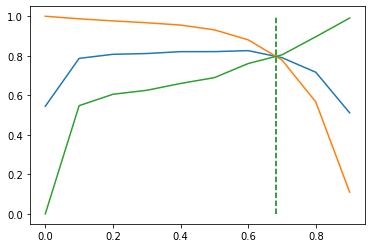

In [106]:
# Plot Accuracy, Recall and Spesificity at diff thresholds

cutoff_df_gan = calculate_labels_at_diff_thresholds(train_pred_df_gan)
plt.plot(cutoff_df_gan['prob'], cutoff_df_gan['accuracy'])
plt.plot(cutoff_df_gan['prob'], cutoff_df_gan['sensi'])
plt.plot(cutoff_df_gan['prob'], cutoff_df_gan['speci'])
plt.vlines(x=.681, ymax=1, ymin=0, colors='g', linestyles='--')

In [107]:
# Calculate labels at optimal threshold and recalculate metrics

train_pred_df_gan['final_predicted'] = train_pred_df_gan.Conv_Prob.map( lambda x: 1 if x > opt_threshold_gan else 0)
evaluate_model(train_pred_df_gan, pred='final_predicted')
train_pred_df_gan.head()

      thresholds       tpr       fpr      spec      diff
1528    0.686976  0.797845  0.202216  0.797784  0.000061
1529    0.686798  0.797848  0.202216  0.797784  0.000065
1530    0.686316  0.797893  0.202279  0.797721  0.000172
1531    0.686312  0.797897  0.202279  0.797721  0.000176
1532    0.686172  0.797923  0.202279  0.797721  0.000202
Accuracy: 0.796, Recall: 0.793, Precision: 0.825, F1-score: 0.809, AUC: 0.882, Specificity: 0.799, G-Mean: 0.796, Optimal Threshold: 0.69


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.069189,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.775254,1,1,1,1,1,1,1,1,1,0,0,1
2,0,0.303627,0,1,1,1,1,0,0,0,0,0,0,0
3,0,0.045209,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.089638,0,1,0,0,0,0,0,0,0,0,0,0


In [108]:
# making predictions on the test set

evaluate_model_on_test_data(train_pred_model_gan, lr_X_val, train_cols_gan, lr_y_val, opt_threshold_gan)

Accuracy: 0.804, Recall: 0.834, Precision: 0.447, F1-score: 0.582, AUC: 0.877, Specificity: 0.798, G-Mean: 0.816


### 6.5. Random Forest - Imbalanced data

In [35]:
def run_random_forest(df_X, df_y, params_grid, scoring):
    best_score_rf = []
    best_estimator_rf = []
    sk_rf = model_selection.StratifiedKFold(n_splits=5)
    for train_ind_base, test_ind_base in sk_rf.split(df_X, df_y):
        X_train_cv, X_test_cv = df_X[train_ind_base], df_X[test_ind_base] 
        y_train_cv, y_test_cv = np.array(df_y)[train_ind_base], np.array(df_y)[test_ind_base]
        print(X_train_cv.shape, y_train_cv.shape, X_test_cv.shape, y_test_cv.shape)
        rf_base = ensemble.RandomForestClassifier(n_jobs=-1, random_state=42)

        gs_rf = model_selection.GridSearchCV(rf_base,
                                             param_grid=params_grid, 
                                             scoring=scoring, 
                                             n_jobs=-1,
                                             verbose=1,
                                             cv=sk_rf, 
                                             return_train_score=True)
        gs_rf.fit(X_train_cv, y_train_cv)
        print(gs_rf.best_score_)
        print(gs_rf.best_estimator_)
        gs_rf_best = gs_rf.best_estimator_
        train_proba_vals = gs_rf_best.predict_proba(X_train_cv)[:,1]
        train_auc = metrics.roc_auc_score(y_train_cv, train_proba_vals)
        test_proba_vals = gs_rf_best.predict_proba(X_test_cv)[:,1]
        test_auc = metrics.roc_auc_score(y_test_cv, test_proba_vals)
        print(f"AUC score on train data is {train_auc}")
        print(f"AUC score on test data is {test_auc}")
        best_score_rf.append(test_auc)
        best_estimator_rf.append(gs_rf_best)
    rf_best = best_estimator_rf[best_score_rf.index(max(best_score_rf))]
    print(rf_best)
    return rf_best

def pca_train_test_data(train_data, test_data, percent_val, compnents_val):
    pca_base = PCA(random_state=42)
    pca_base.fit(train_data)
    var_cumu = np.cumsum(pca_base.explained_variance_ratio_)
    plt.figure(figsize=[12,8])
    plt.hlines(y=percent_val, xmax=40, xmin=0, colors='g', linestyles='--')
    plt.vlines(x=compnents_val, ymax=1, ymin=0, colors='g', linestyles='--')
    plt.plot(var_cumu)
    plt.ylabel('Cumulative Variance Explained')
    pca_final_base = PCA(n_components=compnents_val, random_state=42)
    train_scaled_X_pca_base = pca_final_base.fit_transform(train_data)
    test_scaled_X_pca_base = pca_final_base.transform(test_data)
    print(train_scaled_X_pca_base.shape, test_scaled_X_pca_base.shape)
    return train_scaled_X_pca_base, test_scaled_X_pca_base

def calculate_accuracy_rf(lm, var_list, df, labels, predict_proba=False):
    if predict_proba:
        lr_y_train_pred = lm.predict_proba(df)[:,1]
    else:
        lr_y_train_pred = lm.predict(sm.add_constant(df[var_list])).values.reshape(-1)
    df = pd.DataFrame()
    df['Converted'] = labels.values
    df['Conv_Prob'] = lr_y_train_pred
    df['Predicted'] = df['Conv_Prob'].apply(lambda x : 1 if x > 0.5 else 0)
    cm = metrics.confusion_matrix(df['Converted'], df['Predicted'])
    accuracy = metrics.accuracy_score(df['Converted'], df['Predicted'])
    return df, cm, round(accuracy, 3)

def evaluate_model_on_test_data_rf(mdl_obj, val_x, cols_list, val_y, threshold_val, predict_proba=False):
    if predict_proba:
        y_test_pred = mdl_obj.predict_proba(val_x)[:,1]
    else:
        y_test_pred = mdl_obj.predict(sm.add_constant(val_x[cols_list]))
    y_test_pred_final = pd.DataFrame()
    y_test_pred_final['Converted'] = val_y
    y_test_pred_final['Conv_Prob'] = y_test_pred
    y_test_pred_final['final_predicted'] = y_test_pred_final.Conv_Prob.map(lambda x: 1 if x > threshold_val else 0)
    evaluate_model(y_test_pred_final, pred='final_predicted', train=False)

(267507, 17) (114647, 17)


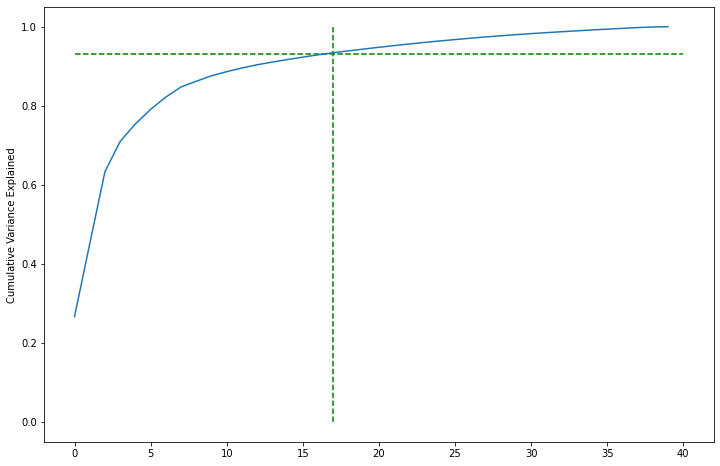

In [36]:
# Transform data

train_scaled_X_pca_imb, test_scaled_X_pca_imb = pca_train_test_data(lr_X_train, lr_X_val, 0.93, 17)

In [ ]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_imb = {
    'n_estimators' : [30, 40, 50, 60, 70, 80],
    'max_depth' : [15, 20, 25],
    'min_samples_leaf' : [25, 30, 35],
    'max_leaf_nodes' : [65, 75, 85, 95, 105, 115]
}

gs_rf_base = run_random_forest(train_scaled_X_pca_imb, lr_y_train, params_rf_imb, 'roc_auc')

(214005, 17) (214005,) (53502, 17) (53502,)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
0.8925536825595082
RandomForestClassifier(max_depth=15, max_leaf_nodes=115, min_samples_leaf=35,
                       n_estimators=80, n_jobs=-1, random_state=42)
AUC score on train data is 0.8975611299949627
AUC score on test data is 0.891534613189559
(214005, 17) (214005,) (53502, 17) (53502,)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
0.8924173702730258
RandomForestClassifier(max_depth=25, max_leaf_nodes=115, min_samples_leaf=25,
                       n_estimators=80, n_jobs=-1, random_state=42)
AUC score on train data is 0.8976369257812528
AUC score on test data is 0.8927947263464544
(214006, 17) (214006,) (53501, 17) (53501,)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
0.8922764970645589
RandomForestClassifier(max_depth=25, max_leaf_nodes=115, min_samples_leaf=25,
                       n_estimators=80, n_jobs=-1, random_state=42)


In [ ]:
gs_rf_base.fit(train_scaled_X_pca_imb, lr_y_train)
rf_train_pred_df_base,_,_ = calculate_accuracy_rf(gs_rf_base, '', train_scaled_X_pca_imb, lr_y_train, predict_proba=True)
rf_train_pred_df_base

In [ ]:
_, _, _, opt_threshold_rf_base = evaluate_model(rf_train_pred_df_base, pred='Predicted')

In [ ]:
# Validate optimal threshold value

cutoff_df_rf_base = calculate_labels_at_diff_thresholds(rf_train_pred_df_base)
plt.plot(cutoff_df_rf_base['prob'], cutoff_df_rf_base['accuracy'])
plt.plot(cutoff_df_rf_base['prob'], cutoff_df_rf_base['sensi'])
plt.plot(cutoff_df_rf_base['prob'], cutoff_df_rf_base['speci'])
plt.vlines(x=.3, ymax=1, ymin=0, colors='g', linestyles='--')

In [ ]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_base['final_predicted'] = rf_train_pred_df_base.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_base else 0)
evaluate_model(rf_train_pred_df_base, pred='final_predicted')
rf_train_pred_df_base.head()

In [ ]:
# validate model on unseen data

evaluate_model_on_test_data_rf(gs_rf_base, test_scaled_X_pca_imb, '', lr_y_val, opt_threshold_rf_base, predict_proba=True)

### 6.6. Random Forest - Balanced data - ADASYN

(440827, 16) (114647, 16)


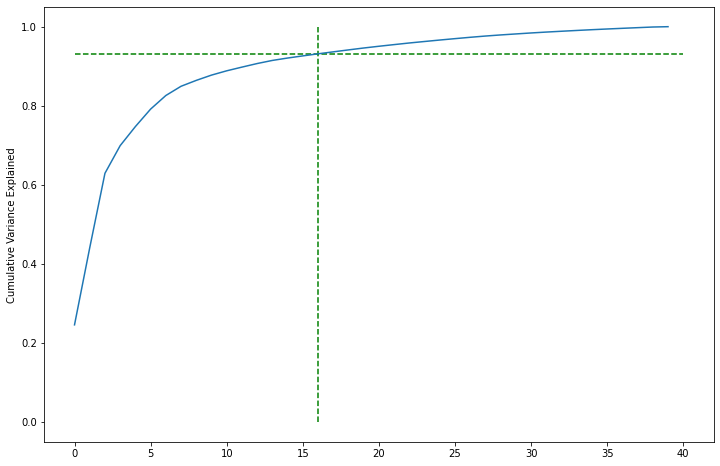

In [136]:
# Transform data

train_scaled_X_pca_bal_ada, test_scaled_X_pca_bal_ada = pca_train_test_data(lr_X_train_ada, lr_X_val, 0.93, 16)

In [144]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_bal_ada = {
    'n_estimators' : [20],
    'max_depth' : [16],
    'min_samples_leaf' : [16],
    'max_leaf_nodes' : [45]
}

gs_rf_bal_ada = run_random_forest(train_scaled_X_pca_bal_ada, lr_y_train_ada, params_rf_bal_ada, 'roc_auc')

(352661, 16) (352661,) (88166, 16) (88166,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8738504214798537
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.8755323732125067
AUC score on test data is 0.8827320643001277
(352661, 16) (352661,) (88166, 16) (88166,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8767534765204046
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.8780407002565946
AUC score on test data is 0.873770138416861
(352662, 16) (352662,) (88165, 16) (88165,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8757091637350332
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train

In [145]:
gs_rf_bal_ada.fit(train_scaled_X_pca_bal_ada, lr_y_train_ada)
rf_train_pred_df_bal_ada,_,_ = calculate_accuracy_rf(gs_rf_bal_ada, '', train_scaled_X_pca_bal_ada, lr_y_train_ada, predict_proba=True)
rf_train_pred_df_bal_ada

,Converted,Conv_Prob,Predicted
0,0,0.040108,0
1,1,0.780704,1
2,0,0.312398,0
3,0,0.027321,0
4,0,0.032954,0
...,...,...,...
440822,1,0.795713,1
440823,1,0.797946,1
440824,1,0.797946,1
440825,1,0.797946,1


In [146]:
_, _, _, opt_threshold_rf_bal_ada = evaluate_model(rf_train_pred_df_bal_ada, pred='Predicted')

       thresholds       tpr       fpr      spec          diff
16684    0.677903  0.804758  0.195242  0.804758  6.366504e-07
16683    0.677914  0.804749  0.195242  0.804758  8.573955e-06
16685    0.677881  0.804763  0.195247  0.804753  9.712505e-06
16682    0.677929  0.804735  0.195242  0.804758  2.238986e-05
16681    0.677930  0.804735  0.195238  0.804762  2.686041e-05
Accuracy: 0.823, Recall: 0.932, Precision: 0.761, F1-score: 0.838, AUC: 0.877, Specificity: 0.716, G-Mean: 0.817, Optimal Threshold: 0.68


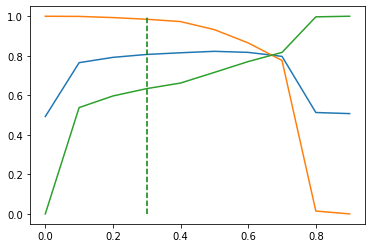

In [147]:
# Validate optimal threshold value

cutoff_df_rf_bal_ada = calculate_labels_at_diff_thresholds(rf_train_pred_df_bal_ada)
plt.plot(cutoff_df_rf_bal_ada['prob'], cutoff_df_rf_bal_ada['accuracy'])
plt.plot(cutoff_df_rf_bal_ada['prob'], cutoff_df_rf_bal_ada['sensi'])
plt.plot(cutoff_df_rf_bal_ada['prob'], cutoff_df_rf_bal_ada['speci'])
plt.vlines(x=.3, ymax=1, ymin=0, colors='g', linestyles='--')

In [148]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_bal_ada['final_predicted'] = rf_train_pred_df_bal_ada.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_bal_ada else 0)
evaluate_model(rf_train_pred_df_bal_ada, pred='final_predicted')
rf_train_pred_df_bal_ada.head()

       thresholds       tpr       fpr      spec          diff
16684    0.677903  0.804758  0.195242  0.804758  6.366504e-07
16683    0.677914  0.804749  0.195242  0.804758  8.573955e-06
16685    0.677881  0.804763  0.195247  0.804753  9.712505e-06
16682    0.677929  0.804735  0.195242  0.804758  2.238986e-05
16681    0.677930  0.804735  0.195238  0.804762  2.686041e-05
Accuracy: 0.804, Recall: 0.802, Precision: 0.8, F1-score: 0.801, AUC: 0.877, Specificity: 0.806, G-Mean: 0.804, Optimal Threshold: 0.68


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.040108,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.780704,1,1,1,1,1,1,1,1,1,0,0,1
2,0,0.312398,0,1,1,1,1,0,0,0,0,0,0,0
3,0,0.027321,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.032954,0,1,0,0,0,0,0,0,0,0,0,0


In [149]:
# validate model on unseen data

evaluate_model_on_test_data_rf(gs_rf_bal_ada, test_scaled_X_pca_bal_ada, '', lr_y_val, opt_threshold_rf_bal_ada, predict_proba=True)

Accuracy: 0.809, Recall: 0.831, Precision: 0.454, F1-score: 0.587, AUC: 0.883, Specificity: 0.804, G-Mean: 0.817


### 6.7. Random Forest - Balanced data - SMOTE

(447372, 16) (114647, 16)


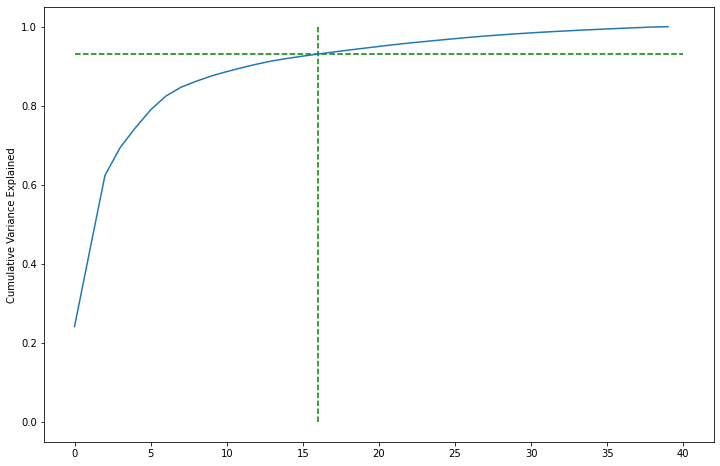

In [151]:
# Transform data

train_scaled_X_pca_bal_smt, test_scaled_X_pca_bal_smt = pca_train_test_data(lr_X_train_smote, lr_X_val, 0.93, 16)

In [152]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_bal_smt = {
    'n_estimators' : [20],
    'max_depth' : [16],
    'min_samples_leaf' : [16],
    'max_leaf_nodes' : [45]
}

gs_rf_bal_smt = run_random_forest(train_scaled_X_pca_bal_smt, lr_y_train_smote, params_rf_bal_smt, 'roc_auc')

(357897, 16) (357897,) (89475, 16) (89475,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8913676792629595
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.8920813271785997
AUC score on test data is 0.8848576288802571
(357897, 16) (357897,) (89475, 16) (89475,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8900021281878873
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.8908218652904333
AUC score on test data is 0.8899209199220994
(357898, 16) (357898,) (89474, 16) (89474,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8893080253825492
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on trai

In [153]:
gs_rf_bal_smt.fit(train_scaled_X_pca_bal_smt, lr_y_train_smote)
rf_train_pred_df_bal_smt,_,_ = calculate_accuracy_rf(gs_rf_bal_smt, '', train_scaled_X_pca_bal_smt, lr_y_train_smote, predict_proba=True)
rf_train_pred_df_bal_smt

,Converted,Conv_Prob,Predicted
0,0,0.045068,0
1,1,0.803723,1
2,0,0.336001,0
3,0,0.024618,0
4,0,0.038379,0
...,...,...,...
447367,1,0.816262,1
447368,1,0.784896,1
447369,1,0.754936,1
447370,1,0.690868,1


In [154]:
_, _, _, opt_threshold_rf_bal_smt = evaluate_model(rf_train_pred_df_bal_smt, pred='Predicted')

       thresholds       tpr       fpr      spec      diff
17131    0.681356  0.820194  0.179815  0.820185  0.000009
17132    0.681338  0.820194  0.179819  0.820181  0.000013
17133    0.681336  0.820199  0.179819  0.820181  0.000018
17134    0.681331  0.820199  0.179824  0.820176  0.000022
17130    0.681357  0.820168  0.179810  0.820190  0.000022
Accuracy: 0.835, Recall: 0.913, Precision: 0.789, F1-score: 0.847, AUC: 0.891, Specificity: 0.756, G-Mean: 0.831, Optimal Threshold: 0.68


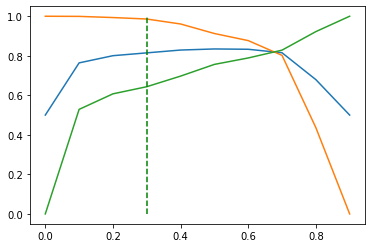

In [155]:
# Validate optimal threshold value

cutoff_df_rf_bal_smt = calculate_labels_at_diff_thresholds(rf_train_pred_df_bal_smt)
plt.plot(cutoff_df_rf_bal_smt['prob'], cutoff_df_rf_bal_smt['accuracy'])
plt.plot(cutoff_df_rf_bal_smt['prob'], cutoff_df_rf_bal_smt['sensi'])
plt.plot(cutoff_df_rf_bal_smt['prob'], cutoff_df_rf_bal_smt['speci'])
plt.vlines(x=.3, ymax=1, ymin=0, colors='g', linestyles='--')

In [156]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_bal_smt['final_predicted'] = rf_train_pred_df_bal_smt.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_bal_smt else 0)
evaluate_model(rf_train_pred_df_bal_smt, pred='final_predicted')
rf_train_pred_df_bal_smt.head()

       thresholds       tpr       fpr      spec      diff
17131    0.681356  0.820194  0.179815  0.820185  0.000009
17132    0.681338  0.820194  0.179819  0.820181  0.000013
17133    0.681336  0.820199  0.179819  0.820181  0.000018
17134    0.681331  0.820199  0.179824  0.820176  0.000022
17130    0.681357  0.820168  0.179810  0.820190  0.000022
Accuracy: 0.821, Recall: 0.821, Precision: 0.82, F1-score: 0.821, AUC: 0.891, Specificity: 0.82, G-Mean: 0.82, Optimal Threshold: 0.68


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.045068,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.803723,1,1,1,1,1,1,1,1,1,1,0,1
2,0,0.336001,0,1,1,1,1,0,0,0,0,0,0,0
3,0,0.024618,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.038379,0,1,0,0,0,0,0,0,0,0,0,0


In [157]:
# validate model on unseen data

evaluate_model_on_test_data_rf(gs_rf_bal_smt, test_scaled_X_pca_bal_smt, '', lr_y_val, opt_threshold_rf_bal_smt, predict_proba=True)

Accuracy: 0.815, Recall: 0.799, Precision: 0.463, F1-score: 0.587, AUC: 0.884, Specificity: 0.819, G-Mean: 0.809


### 6.8. Random Forest - Balanced data - GAN

(491193, 16) (114647, 16)


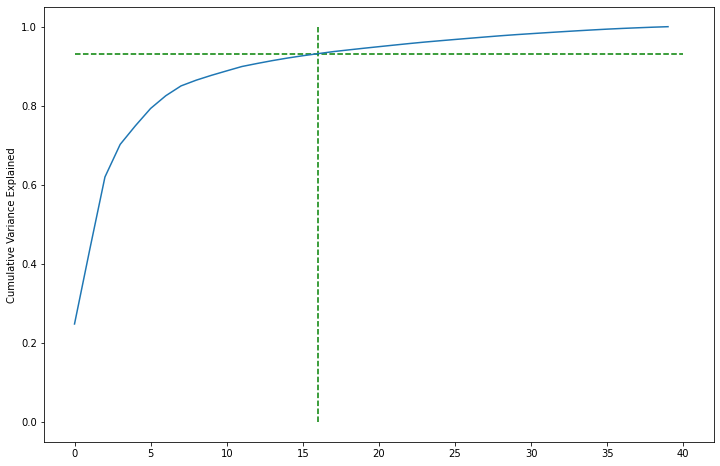

In [158]:
# Transform data

train_scaled_X_pca_bal_gan, test_scaled_X_pca_bal_gan = pca_train_test_data(lr_X_train_gan_bal, lr_X_val, 0.93, 16)

In [159]:
%%time

# Fit random Forest model with hyperparameters.

params_rf_bal_gan = {
    'n_estimators' : [20],
    'max_depth' : [16],
    'min_samples_leaf' : [16],
    'max_leaf_nodes' : [45]
}

gs_rf_bal_gan = run_random_forest(train_scaled_X_pca_bal_gan, lr_y_train_gan_bal, params_rf_bal_gan, 'roc_auc')

(392954, 16) (392954,) (98239, 16) (98239,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9248575973709977
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.9248580077524577
AUC score on test data is 0.8702212048482222
(392954, 16) (392954,) (98239, 16) (98239,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9060565668276531
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on train data is 0.9109831215918113
AUC score on test data is 0.9186376886436163
(392954, 16) (392954,) (98239, 16) (98239,)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.9057438185154808
RandomForestClassifier(max_depth=16, max_leaf_nodes=45, min_samples_leaf=16,
                       n_estimators=20, n_jobs=-1, random_state=42)
AUC score on trai

In [160]:
gs_rf_bal_gan.fit(train_scaled_X_pca_bal_gan, lr_y_train_gan_bal)
rf_train_pred_df_bal_gan,_,_ = calculate_accuracy_rf(gs_rf_bal_gan, '', train_scaled_X_pca_bal_gan, lr_y_train_gan_bal, predict_proba=True)
rf_train_pred_df_bal_gan

,Converted,Conv_Prob,Predicted
0,0,0.067968,0
1,1,0.615429,1
2,0,0.108543,0
3,0,0.073787,0
4,0,0.060071,0
...,...,...,...
491188,1,0.836743,1
491189,1,0.798146,1
491190,1,0.890838,1
491191,1,0.891812,1


In [161]:
_, _, _, opt_threshold_rf_bal_gan = evaluate_model(rf_train_pred_df_bal_gan, pred='Predicted')

       thresholds       tpr       fpr      spec      diff
34510    0.678405  0.826240  0.173752  0.826248  0.000007
34511    0.678388  0.826255  0.173752  0.826248  0.000008
34512    0.678378  0.826262  0.173752  0.826248  0.000015
34509    0.678413  0.826236  0.173748  0.826252  0.000016
34513    0.678376  0.826266  0.173752  0.826248  0.000019
Accuracy: 0.843, Recall: 0.949, Precision: 0.8, F1-score: 0.869, AUC: 0.912, Specificity: 0.717, G-Mean: 0.825, Optimal Threshold: 0.68


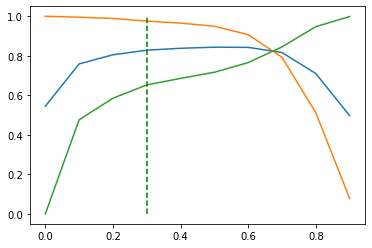

In [162]:
# Validate optimal threshold value

cutoff_df_rf_bal_gan = calculate_labels_at_diff_thresholds(rf_train_pred_df_bal_gan)
plt.plot(cutoff_df_rf_bal_gan['prob'], cutoff_df_rf_bal_gan['accuracy'])
plt.plot(cutoff_df_rf_bal_gan['prob'], cutoff_df_rf_bal_gan['sensi'])
plt.plot(cutoff_df_rf_bal_gan['prob'], cutoff_df_rf_bal_gan['speci'])
plt.vlines(x=.3, ymax=1, ymin=0, colors='g', linestyles='--')

In [163]:
# Reevaluate model with optimal threshold value

rf_train_pred_df_bal_gan['final_predicted'] = rf_train_pred_df_bal_gan.Conv_Prob.map( lambda x: 1 if x > opt_threshold_rf_bal_gan else 0)
evaluate_model(rf_train_pred_df_bal_gan, pred='final_predicted')
rf_train_pred_df_bal_gan.head()

       thresholds       tpr       fpr      spec      diff
34510    0.678405  0.826240  0.173752  0.826248  0.000007
34511    0.678388  0.826255  0.173752  0.826248  0.000008
34512    0.678378  0.826262  0.173752  0.826248  0.000015
34509    0.678413  0.826236  0.173748  0.826252  0.000016
34513    0.678376  0.826266  0.173752  0.826248  0.000019
Accuracy: 0.826, Recall: 0.824, Precision: 0.851, F1-score: 0.838, AUC: 0.912, Specificity: 0.827, G-Mean: 0.825, Optimal Threshold: 0.68


,Converted,Conv_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.067968,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.615429,1,1,1,1,1,1,1,1,0,0,0,0
2,0,0.108543,0,1,1,0,0,0,0,0,0,0,0,0
3,0,0.073787,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.060071,0,1,0,0,0,0,0,0,0,0,0,0


In [164]:
# validate model on unseen data

evaluate_model_on_test_data_rf(gs_rf_bal_gan, test_scaled_X_pca_bal_gan, '', lr_y_val, opt_threshold_rf_bal_gan, predict_proba=True)

Accuracy: 0.8, Recall: 0.669, Precision: 0.429, F1-score: 0.523, AUC: 0.867, Specificity: 0.825, G-Mean: 0.743
